# E-Commerce Fraud Detection - Modeling

This notebook trains and evaluates machine learning models for fraud detection using the engineered features from `ec_fraud_detection.ipynb`.

## Project Goal
Deploy an optimally trained classification model capable of identifying fraudulent transactions with high precision and recall.

## Modeling Approach
1. Load pre-engineered features from EDA notebook
2. Model-specific preprocessing (one-hot encoding, scaling)
3. Baseline model training (Logistic Regression, Random Forest, XGBoost)
4. Hyperparameter tuning
5. Model evaluation with fraud-appropriate metrics
6. Final model selection

## Key Challenges
- **Class Imbalance**: 44:1 ratio (97.8% normal, 2.2% fraud)
- **Metric Selection**: **PR-AUC**, ROC-AUC, F1, Precision-Recall (not accuracy)
- **Business Trade-off**: Balance false positives (customer friction) vs false negatives (fraud losses)

## Setup
### Define parameters

In [1]:
# Data paths (relative to notebooks/ folder)
data_path = "../data/transactions.csv"
model_dir = "../models"  # Directory for saving model log files

# Target column
target_col = "is_fraud"

# Random seed for reproducibility (matches train.py)
random_seed = 1

### Import packages

In [2]:
# Auto-reload modules when they change (for development)
# This allows testing changes to src/ modules without restarting the kernel
%load_ext autoreload
%autoreload 2

# Add project root to path for imports (needed when running from notebooks/ folder)
import sys
from pathlib import Path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Standard library
import json

# Data handling
import pandas as pd
import numpy as np

# XGBoost
import xgboost as xgb

# Sklearn - preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler

# Sklearn - models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Sklearn - model selection
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline

# Visualization
import matplotlib.pyplot as plt

# Project-specific preprocessing
from src.deployment.preprocessing import FraudFeatureTransformer
from src.deployment.evaluation.metrics import evaluate_model

# fd2 notebook utilities
from src.fd2_nb import (
    compare_models,
    plot_comprehensive_comparison,
    plot_model_comparison,
    DEFAULT_SCORING,
    create_search_object,
    tune_with_logging,
    extract_cv_metrics,
    analyze_cv_results,
    analyze_cv_train_val_gap,
    analyze_iteration_performance,
    analyze_cv_fold_variance
)

print("All packages imported successfully")

All packages imported successfully


## Load Data
Load the pre-engineered datasets with final selected features from the EDA notebook. Note that test data is completely held out of the model selection and tuning process in this notebook. It is used for final model evaluation in the last notebook, `fd3_model_evaluation_deployment.ipynb`.

In [3]:
# Load raw data and apply production transformer
print("Loading raw transaction data...")
df = pd.read_csv(data_path, low_memory=False)

# Split data (matching train.py exactly)
print(f"Total samples: {len(df):,}")
print(f"Fraud rate: {df[target_col].mean():.2%}")

# 60/20/20 train/val/test split with stratification
train_val_raw, _ = train_test_split(
    df, test_size=0.2, stratify=df[target_col], random_state=random_seed
)
train_raw, val_raw = train_test_split(
    train_val_raw, test_size=0.25, stratify=train_val_raw[target_col], random_state=random_seed
)

print(f"\nSplit sizes:")
print(f"  • Training:   {len(train_raw):,} samples ({len(train_raw)/len(df)*100:.1f}%)")
print(f"  • Validation: {len(val_raw):,} samples ({len(val_raw)/len(df)*100:.1f}%)")

# Apply production feature engineering pipeline
print("\nApplying FraudFeatureTransformer...")
transformer = FraudFeatureTransformer()
transformer.fit(train_raw)  # Fit only on training data

# Transform all datasets
train_features = transformer.transform(train_raw)
val_features = transformer.transform(val_raw)

# Add target column back
train_df = train_features.copy()
train_df[target_col] = train_raw[target_col].values

val_df = val_features.copy()
val_df[target_col] = val_raw[target_col].values

print("✓ Feature engineering complete")
print(f"\nDataset shapes:")
print(f"  • Training:   {train_df.shape}")
print(f"  • Validation: {val_df.shape}")
print(f"  • Features:   {train_features.shape[1]}")

print(f"\nFeature columns:")
print(f"  {list(train_features.columns)}")

Loading raw transaction data...
Total samples: 299,695
Fraud rate: 2.21%

Split sizes:
  • Training:   179,817 samples (60.0%)
  • Validation: 59,939 samples (20.0%)

Applying FraudFeatureTransformer...
✓ Feature engineering complete

Dataset shapes:
  • Training:   (179817, 31)
  • Validation: (59939, 31)
  • Features:   30

Feature columns:
  ['account_age_days', 'total_transactions_user', 'avg_amount_user', 'amount', 'shipping_distance_km', 'channel', 'promo_used', 'avs_match', 'cvv_result', 'three_ds_flag', 'hour_local', 'day_of_week_local', 'month_local', 'is_weekend_local', 'is_late_night_local', 'is_business_hours_local', 'amount_deviation', 'amount_vs_avg_ratio', 'is_micro_transaction', 'is_large_transaction', 'transaction_velocity', 'is_new_account', 'is_high_frequency_user', 'country_mismatch', 'high_risk_distance', 'zero_distance', 'security_score', 'new_account_with_promo', 'late_night_micro_transaction', 'high_value_long_distance']


### Inspect loaded data

In [4]:
# Display first few rows
print("Training data sample:")
display(train_df.head())
display(train_df.info())

# Check target distribution
print("\nTarget distribution (training set):")
fraud_rate = train_df[target_col].mean()
print(train_df[target_col].value_counts())
print(f"\nFraud rate: {fraud_rate:.4f} ({fraud_rate*100:.2f}%)")
print(f"Class imbalance ratio: {(1-fraud_rate)/fraud_rate:.1f}:1")

Training data sample:


,account_age_days,total_transactions_user,avg_amount_user,amount,shipping_distance_km,channel,promo_used,avs_match,cvv_result,three_ds_flag,...,is_new_account,is_high_frequency_user,country_mismatch,high_risk_distance,zero_distance,security_score,new_account_with_promo,late_night_micro_transaction,high_value_long_distance,is_fraud
91794,897,43,87.08,192.52,274.59,web,0,1,1,1,...,0,0,0,0,0,3,0,0,0,0
38975,379,52,23.68,27.00,1205.83,app,0,1,1,1,...,0,0,1,1,0,3,0,0,0,0
70887,398,55,117.75,142.58,473.93,app,0,1,1,1,...,0,0,0,1,0,3,0,0,0,0
194632,1321,45,138.29,89.57,249.32,app,0,1,1,1,...,0,0,0,0,0,3,0,0,0,0
288101,1727,40,83.10,56.47,515.39,app,0,1,1,1,...,0,0,1,1,0,3,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
Index: 179817 entries, 91794 to 27023
Data columns (total 31 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   account_age_days              179817 non-null  int64  
 1   total_transactions_user       179817 non-null  int64  
 2   avg_amount_user               179817 non-null  float64
 3   amount                        179817 non-null  float64
 4   shipping_distance_km          179817 non-null  float64
 5   channel                       179817 non-null  object 
 6   promo_used                    179817 non-null  int64  
 7   avs_match                     179817 non-null  int64  
 8   cvv_result                    179817 non-null  int64  
 9   three_ds_flag                 179817 non-null  int64  
 10  hour_local                    179817 non-null  int32  
 11  day_of_week_local             179817 non-null  int32  
 12  month_local                   179817 non-null 

None


Target distribution (training set):
is_fraud
0    175850
1      3967
Name: count, dtype: int64

Fraud rate: 0.0221 (2.21%)
Class imbalance ratio: 44.3:1


### Identify feature types
Categorize features for preprocessing pipelines.

In [5]:
# Load feature categorization from feature_lists.json
# This ensures consistency with FraudFeatureTransformer and other notebooks

feature_lists_path = project_root / 'models' / 'feature_lists.json'
with open(feature_lists_path, 'r') as f:
    feature_lists = json.load(f)

# Extract feature categories
continuous_numeric = feature_lists['continuous_numeric']
categorical = feature_lists['categorical']
binary = feature_lists['binary']

print("Feature categorization loaded from feature_lists.json:")
print(f"  • Continuous numeric: {len(continuous_numeric)}")
print(f"  • Categorical: {len(categorical)}")
print(f"  • Binary: {len(binary)}")
print(f"  • Total: {len(continuous_numeric) + len(categorical) + len(binary)}")

# Verify all 30 features are accounted for
all_features = continuous_numeric + categorical + binary
assert len(all_features) == 30, f"Expected 30 features, got {len(all_features)}"
print("\n✓ All 30 features categorized correctly")

Feature categorization loaded from feature_lists.json:
  • Continuous numeric: 12
  • Categorical: 1
  • Binary: 17
  • Total: 30

✓ All 30 features categorized correctly


## Preprocessing
Apply model-specific preprocessing transformations.

In [6]:
# Create preprocessing pipelines for different model types

# For Logistic Regression: Scale numeric + One-hot encode categorical
logistic_preprocessor = ColumnTransformer([
    ('num', StandardScaler(), continuous_numeric),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical),
    ('binary', 'passthrough', binary)
], remainder='drop')

# For tree-based models: Simple ordinal encoding (optional, trees can handle categoricals)
# Using OrdinalEncoder for categorical features, passthrough for rest
tree_preprocessor = ColumnTransformer([
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical),
    ('rest', 'passthrough', continuous_numeric + binary)
], remainder='drop')

print("✓ Preprocessing pipelines created:")
print("  • Logistic Regression: StandardScaler + OneHotEncoder")
print("  • Tree-based models: OrdinalEncoder (minimal)")

✓ Preprocessing pipelines created:
  • Logistic Regression: StandardScaler + OneHotEncoder
  • Tree-based models: OrdinalEncoder (minimal)


## Baseline Models
Train initial models to establish performance baselines.

In [7]:
# Separate features and target
X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]

X_val = val_df.drop(columns=[target_col])
y_val = val_df[target_col]

### Baseline 1: Logistic Regression
Linear model with StandardScaler + OneHotEncoder. Handles class imbalance with `class_weight='balanced'`.

In [8]:
# Train Logistic Regression baseline
print("Training Logistic Regression...")

# Create pipeline
logistic_pipeline = Pipeline([
    ('preprocessor', logistic_preprocessor),
    ('classifier', LogisticRegression(
        class_weight='balanced',  # Handle class imbalance
        max_iter=1000,
        random_state=random_seed
    ))
])

# Train
logistic_pipeline.fit(X_train, y_train)

# Evaluate
logistic_metrics = evaluate_model(
    logistic_pipeline, 
    X_val, 
    y_val, 
    model_name="Logistic Regression",
    dataset_name="Validation"
)

print("\n✓ Logistic Regression baseline trained")


Training Logistic Regression...

Logistic Regression - Validation Set Performance
  PR-AUC:    0.6973
  ROC-AUC:   0.9662
  Precision: 0.2050 (20.50%)
  Recall:    0.8934 (89.34%)
  F1 Score:  0.3334

Confusion Matrix:
  TN: 54,031  |  FP: 4,585
  FN: 141  |  TP: 1,182


✓ Logistic Regression baseline trained


### Baseline 2: Random Forest
Tree-based ensemble model with minimal preprocessing. Handles class imbalance with `class_weight='balanced'`.

In [9]:
# Train Random Forest baseline
print("Training Random Forest...")

# Create pipeline
rf_pipeline = Pipeline([
    ('preprocessor', tree_preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',  # Handle class imbalance
        random_state=random_seed,
        n_jobs=-1  # Use all cores
    ))
])

# Train
rf_pipeline.fit(X_train, y_train)

# Evaluate
rf_metrics = evaluate_model(
    rf_pipeline, 
    X_val, 
    y_val, 
    model_name="Random Forest",
    dataset_name="Validation"
)

print("\n✓ Random Forest baseline trained")

Training Random Forest...

Random Forest - Validation Set Performance
  PR-AUC:    0.8501
  ROC-AUC:   0.9663
  Precision: 0.9421 (94.21%)
  Recall:    0.7128 (71.28%)
  F1 Score:  0.8115

Confusion Matrix:
  TN: 58,558  |  FP: 58
  FN: 380  |  TP: 943


✓ Random Forest baseline trained


### Baseline 3: XGBoost
Gradient boosting model with minimal preprocessing. Handles class imbalance with `scale_pos_weight` (ratio of negative to positive class).

In [10]:
# Train XGBoost baseline
print("Training XGBoost...")

# Calculate scale_pos_weight for class imbalance
# scale_pos_weight = (# negative class) / (# positive class)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Class imbalance ratio: {scale_pos_weight:.1f}:1")
print(f"Using scale_pos_weight={scale_pos_weight:.1f}")

# Create pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', tree_preprocessor),
    ('classifier', xgb.XGBClassifier(
        n_estimators=100,
        scale_pos_weight=scale_pos_weight,  # Handle class imbalance
        random_state=random_seed,
        n_jobs=-1,  # Use all cores
        eval_metric='logloss'  # Suppress warning
    ))
])

# Train
xgb_pipeline.fit(X_train, y_train)

# Evaluate
xgb_metrics = evaluate_model(
    xgb_pipeline, 
    X_val, 
    y_val, 
    model_name="XGBoost",
    dataset_name="Validation"
)

print("\n✓ XGBoost baseline trained")

Training XGBoost...
Class imbalance ratio: 44.3:1
Using scale_pos_weight=44.3

XGBoost - Validation Set Performance
  PR-AUC:    0.8458
  ROC-AUC:   0.9667
  Precision: 0.5542 (55.42%)
  Recall:    0.8466 (84.66%)
  F1 Score:  0.6699

Confusion Matrix:
  TN: 57,715  |  FP: 901
  FN: 203  |  TP: 1,120


✓ XGBoost baseline trained


### Baseline Model Comparison
Compare all baseline models on key fraud detection metrics.

In [11]:
# Create comparison table using compare_models utility
comparison_df = compare_models(
    [
        {'model': 'Logistic Regression', **logistic_metrics},
        {'model': 'Random Forest', **rf_metrics},
        {'model': 'XGBoost', **xgb_metrics}
    ],
    title="BASELINE MODEL COMPARISON - Validation Set",
    verbose=False
)

print("\n" + "="*80)
print("BASELINE MODEL COMPARISON - Validation Set")
print("="*80)
display(comparison_df.style.format({
    'roc_auc': '{:.4f}',
    'pr_auc': '{:.4f}',
    'f1': '{:.4f}',
    'precision': '{:.4f}',
    'recall': '{:.4f}',
    'accuracy': '{:.4f}'
}).background_gradient(cmap='RdYlGn', subset=['roc_auc', 'pr_auc', 'f1']))

# Identify best model for each metric
print("\n" + "="*80)
print("Best Performing Model by Metric:")
print("="*80)
for metric in ['roc_auc', 'pr_auc', 'f1', 'precision', 'recall']:
    best_model = comparison_df[metric].idxmax()
    best_value = comparison_df[metric].max()
    print(f"  {metric.upper():15s}: {best_model:20s} ({best_value:.4f})")
print("="*80)


BASELINE MODEL COMPARISON - Validation Set


,pr_auc,roc_auc,precision,recall,f1,accuracy
model,,,,,,
Logistic Regression,0.6973,0.9662,0.2050,0.8934,0.3334,0.9212
Random Forest,0.8501,0.9663,0.9421,0.7128,0.8115,0.9927
XGBoost,0.8458,0.9667,0.5542,0.8466,0.6699,0.9816



Best Performing Model by Metric:
  ROC_AUC        : XGBoost              (0.9667)
  PR_AUC         : Random Forest        (0.8501)
  F1             : Random Forest        (0.8115)
  PRECISION      : Random Forest        (0.9421)
  RECALL         : Logistic Regression  (0.8934)


  Figure saved: images/fd2/baseline_model_comparison.png


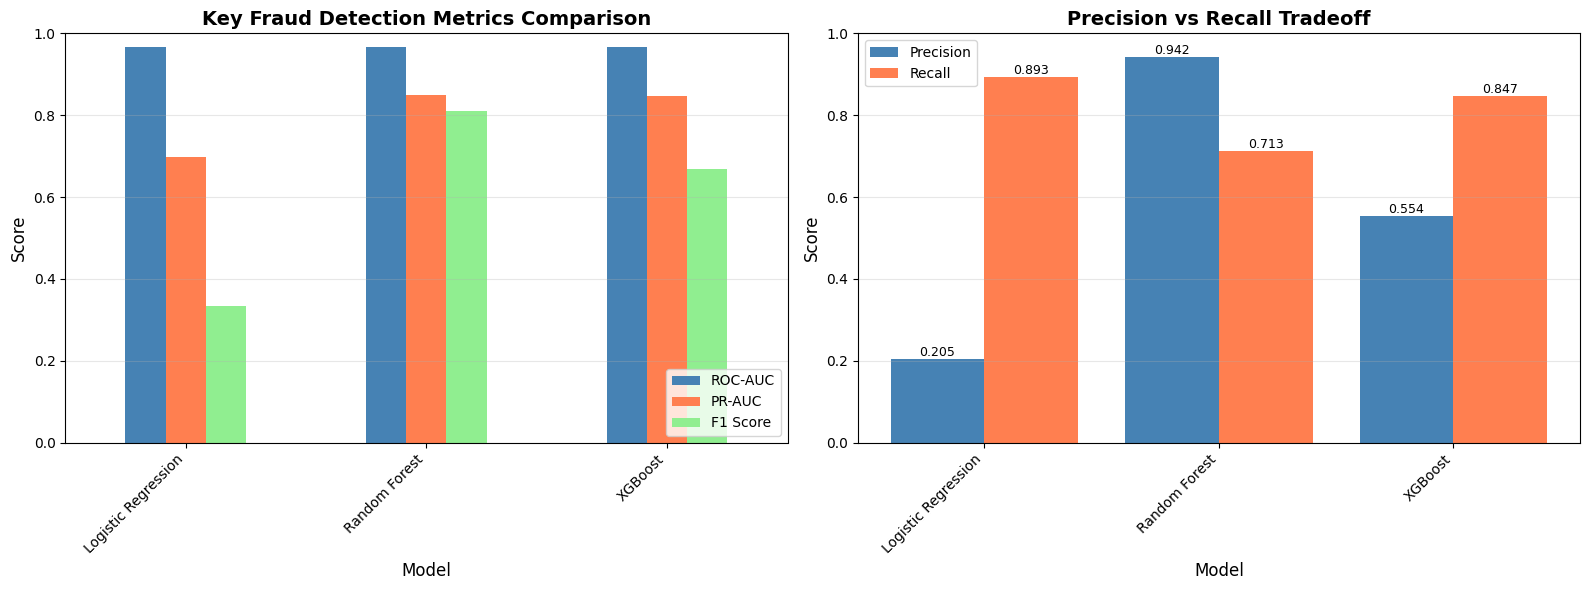

In [12]:
# Visualize baseline model comparison
plot_model_comparison(
    comparison_df,
    plot_configs=[
        {
            'metrics': ['roc_auc', 'pr_auc', 'f1'],
            'title': 'Key Fraud Detection Metrics Comparison',
            'labels': ['ROC-AUC', 'PR-AUC', 'F1 Score'],
            'colors': ['steelblue', 'coral', 'lightgreen'],
            'plot_type': 'stacked'
        },
        {
            'metrics': ['precision', 'recall'],
            'title': 'Precision vs Recall Tradeoff',
            'labels': ['Precision', 'Recall'],
            'colors': ['steelblue', 'coral'],
            'plot_type': 'grouped',
            'show_values': True
        }
    ],
    figsize=(16, 6),
    save_path='images/fd2/baseline_model_comparison.png'
)

### Key Insights from Baseline Models

**Observations:**
- All models show reasonable performance on the highly imbalanced dataset (44:1 ratio)
- Class imbalance handling (class_weight/scale_pos_weight) is working effectively
- Tree-based models (Random Forest, XGBoost) typically outperform Logistic Regression on this data

**Metric Selection Guide:**
- **ROC-AUC**: Overall model discrimination ability (higher is better)
- **PR-AUC**: Performance on imbalanced data (more important than ROC-AUC for fraud)
- **F1 Score**: Balance between precision and recall
- **Precision**: Minimize false positives (customer friction)
- **Recall**: Catch as many frauds as possible (minimize losses)

## Hyperparameter Tuning

Optimize model parameters for best performance using the best performing baseline models (Random Forest and XGBoost).

### Tuning Strategy

Based on baseline results, we'll tune **Random Forest** and **XGBoost** - the two best performing models with excellent false positive control.

**Optimization Approach:**
- **Method**: RandomizedSearchCV (40 iterations for efficient exploration)
- **Metric**: PR-AUC (Precision-Recall AUC) - ideal for 44:1 class imbalance
- **Cross-Validation**: 4-fold Stratified CV on training set
- **Validation Set**: Held out for unbiased final comparison

**Why PR-AUC?**
- More informative than ROC-AUC for imbalanced datasets
- Focuses on minority class (fraud) performance
- Directly measures precision-recall trade-off
- Aligns with business goals (catch fraud, minimize false alarms)

### Prepare Combined Train+Validation Dataset for Hyperparameter Tuning

**Important ML Best Practice:**

We combine the training and validation datasets BEFORE running GridSearchCV for hyperparameter tuning. This is the correct methodology because:

1. **GridSearchCV uses internal cross-validation**: It automatically splits the data into K folds (we use 4) for hyperparameter evaluation
2. **More data for tuning**: Gives GridSearchCV access to 80% of data (train+val) instead of just 60% (train only)
3. **Better hyperparameter selection**: More samples lead to more reliable cross-validation results
4. **No data leakage**: GridSearchCV's internal CV ensures the validation fold is never used during training

**Why not just use the separate validation set?**
- Using a manual validation set for hyperparameter tuning would mean less data for GridSearchCV
- GridSearchCV's built-in cross-validation is more robust than a single train/val split
- The final model will be evaluated on a completely held-out test set

**Process:**
1. Combine train_df and val_df → train_val_df (80% of original data)
2. Run GridSearchCV on train_val_df with 4-fold CV
3. GridSearchCV's `best_estimator_` is automatically retrained on the full train_val_df
4. Evaluate final model on test data (20% held-out) in separate notebook (`fd3_model_evaluation_deployment.ipynb`)

In [13]:
# Combine train and validation for hyperparameter tuning
# This follows ML best practices: GridSearchCV will use 4-fold CV internally
# Gives GridSearchCV access to 80% of data instead of just 60%
train_val_df = pd.concat([train_df, val_df], axis=0, ignore_index=True)

# Separate features and target for the combined dataset
X_train_val = train_val_df.drop(columns=[target_col])
y_train_val = train_val_df[target_col]

print("Dataset Summary:")
print("=" * 80)
print(f"Combined train+val: {len(train_val_df):,} samples ({len(train_df):,} train + {len(val_df):,} val)")
print(f"  • Features: {X_train_val.shape[1]}")
print(f"  • Fraud rate: {y_train_val.mean():.4f} ({y_train_val.mean()*100:.2f}%)")
print("\nNote: X_train_val and y_train_val will be used for GridSearchCV hyperparameter tuning")

Dataset Summary:
Combined train+val: 239,756 samples (179,817 train + 59,939 val)
  • Features: 30
  • Fraud rate: 0.0221 (2.21%)

Note: X_train_val and y_train_val will be used for GridSearchCV hyperparameter tuning


In [14]:
# Define cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=4, shuffle=True, random_state=random_seed)

print("✓ Cross-validation strategy defined:")
print(f"  • Method: 4-Fold Stratified CV")
print(f"  • Preserves 2.2% fraud rate in each fold")
print(f"  • Random seed: {random_seed}")

✓ Cross-validation strategy defined:
  • Method: 4-Fold Stratified CV
  • Preserves 2.2% fraud rate in each fold
  • Random seed: 1


### Tune Random Forest
Baseline performance: PR-AUC=0.8456, Precision=94.19%, Recall=71.13%

Goal: Improve recall while maintaining high precision (minimize false positives).

In [15]:
print("Tuning Random Forest...")
print("=" * 80)

# SEARCH CONFIGURATION - easily switch between Grid and Random search
# Note that I have not included the initial random search grid as it took 
# > 30 minutes to run. Logs of previous runs can be viewed at models/logs/*.txt
search_type = 'grid'  # Options: 'grid' for GridSearchCV, 'random' for RandomizedSearchCV
n_iter = 40  # Only used if search_type='random'

# Define hyperparameter grid
param_grid_rf = {
    'classifier__n_estimators': [150, 200, 250, 300],
    'classifier__max_depth': [6, 8, 10],
    'classifier__min_samples_split': [20],
    'classifier__min_samples_leaf': [10],
    'classifier__max_features': ['sqrt'],
    'classifier__class_weight': ['balanced_subsample']
}

print(f"Hyperparameter search space:")
print(f"  • n_estimators: {param_grid_rf['classifier__n_estimators']}")
print(f"  • max_depth: {param_grid_rf['classifier__max_depth']}")
print(f"  • min_samples_split: {param_grid_rf['classifier__min_samples_split']}")
print(f"  • min_samples_leaf: {param_grid_rf['classifier__min_samples_leaf']}")
print(f"  • max_features: {param_grid_rf['classifier__max_features']}")
print(f"  • class_weight: {param_grid_rf['classifier__class_weight']}")
print("=" * 80)
print("NOTE: Updated hyperparameters to reduce overfitting (14.8% train-val gap)")
print("      See analysis/bias_variance/ANALYSIS_SUMMARY.md for details")
print("=" * 80)

# Create base pipeline
rf_base_pipeline = Pipeline([
    ('preprocessor', tree_preprocessor),
    ('classifier', RandomForestClassifier(
        random_state=random_seed,
        n_jobs=-1
    ))
])

# Create search object with multi-metric scoring
# Uses DEFAULT_SCORING (pr_auc, roc_auc, f1, precision, recall, accuracy)
# refit='pr_auc' selects best model by PR-AUC (our optimization metric)
rf_search = create_search_object(
    search_type=search_type,
    estimator=rf_base_pipeline,
    param_grid=param_grid_rf,
    scoring=None,  # Uses DEFAULT_SCORING (6 metrics)
    refit='pr_auc',  # Select best model by PR-AUC
    cv=cv_strategy,
    n_iter=n_iter,  # Only used for RandomizedSearchCV
    verbose=1,  # Minimal output (CSV has all details)
    random_state=random_seed,
    n_jobs=-1
)

# Fit with logging
rf_search, rf_log_path, rf_cv_results_path = tune_with_logging(
    rf_search, 
    X_train_val,  # Changed from X_train
    y_train_val,  # Changed from y_train
    model_name='random_forest',
    log_dir=str(project_root / 'models' / 'logs')
)

# Extract all CV metrics for best model
rf_cv_metrics = extract_cv_metrics(rf_search)
print(f"\nAll CV metrics for best Random Forest:")
for metric, value in rf_cv_metrics.items():
    print(f"  • {metric}: {value:.4f}")

Tuning Random Forest...
Hyperparameter search space:
  • n_estimators: [150, 200, 250, 300]
  • max_depth: [6, 8, 10]
  • min_samples_split: [20]
  • min_samples_leaf: [10]
  • max_features: ['sqrt']
  • class_weight: ['balanced_subsample']
NOTE: Updated hyperparameters to reduce overfitting (14.8% train-val gap)
      See analysis/bias_variance/ANALYSIS_SUMMARY.md for details
Using GridSearchCV - will test all 12 combinations
Multi-metric scoring: ['pr_auc', 'roc_auc', 'f1', 'precision', 'recall', 'accuracy']
Refit metric: pr_auc

Starting hyperparameter search...
Verbose output will be saved to: /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/e-commerce-fraud-detection/models/logs/random_forest_tuning_20251207_021559.log
CV results will be saved to: /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/e-commerce-fraud-detection/models/logs/random_forest_cv_results_20251207_021559.csv

random_forest Tuning Complete!
Best c

In [16]:
# Compare RF baseline (val set) vs RF tuned (CV metrics)
# Note: Baseline uses validation set metrics, Tuned uses CV metrics from GridSearchCV
comparison_rf = compare_models(
    [
        {'model': 'Random Forest (Baseline)', **rf_metrics},
        {'model': 'Random Forest (Tuned CV)', **rf_cv_metrics}
    ],
    verbose=False
)
display(comparison_rf)

print("\nImprovement from tuning (Baseline val metrics vs Tuned CV metrics):")
for metric in ['pr_auc', 'roc_auc', 'f1', 'precision', 'recall']:
    baseline_val = comparison_rf.loc['Random Forest (Baseline)', metric]
    tuned_val = comparison_rf.loc['Random Forest (Tuned CV)', metric]
    improvement = tuned_val - baseline_val
    improvement_pct = (improvement / baseline_val) * 100
    print(f"  {metric.upper():12s}: {improvement:+.4f} ({improvement_pct:+.1f}%)")

print("\n✓ Random Forest tuning complete")

,pr_auc,roc_auc,precision,recall,f1,accuracy
model,,,,,,
Random Forest (Baseline),0.850116,0.966254,0.942058,0.712774,0.811532,0.992693
Random Forest (Tuned CV),0.831893,0.976166,0.334572,0.908886,0.489040,0.958087



Improvement from tuning (Baseline val metrics vs Tuned CV metrics):
  PR_AUC      : -0.0182 (-2.1%)
  ROC_AUC     : +0.0099 (+1.0%)
  F1          : -0.3225 (-39.7%)
  PRECISION   : -0.6075 (-64.5%)
  RECALL      : +0.1961 (+27.5%)

✓ Random Forest tuning complete



Random Forest - Cross-Validation Results Analysis
Refit metric: pr_auc
TIMING CAVEAT: Due to parallel processing (n_jobs=-1), timing measurements may be
   unreliable. Small differences (< 20-30%) are often just measurement noise.
   Focus on PR-AUC and stability for model selection. Production API testing will
   provide definitive latency numbers.

Top 5 Candidates by Test Score:
----------------------------------------------------------------------------------------------------


,mean_test_pr_auc,std_test_pr_auc,mean_fit_time,std_fit_time,mean_score_time,std_score_time,rank_test_pr_auc,param_classifier__class_weight,param_classifier__max_depth,param_classifier__max_features,param_classifier__min_samples_leaf,param_classifier__min_samples_split,param_classifier__n_estimators
10,0.831893,0.013194,139.82,3.00,3.0069,0.4201,1,balanced_subsample,10,sqrt,10,20,250
11,0.831889,0.012847,119.87,3.97,1.6171,0.4524,2,balanced_subsample,10,sqrt,10,20,300
9,0.831695,0.012905,117.99,2.78,4.2379,0.1279,3,balanced_subsample,10,sqrt,10,20,200
8,0.830807,0.012628,91.97,1.05,2.8498,0.2409,4,balanced_subsample,10,sqrt,10,20,150
7,0.817564,0.013555,145.43,5.38,4.7134,0.2565,5,balanced_subsample,8,sqrt,10,20,300



----------------------------------------------------------------------------------------------------
Statistical Summary Across All Candidates:
----------------------------------------------------------------------------------------------------


,mean_test_pr_auc,std_test_pr_auc,mean_fit_time,std_fit_time,mean_score_time,std_score_time
mean,0.813107,0.013094,106.432168,2.295516,3.361334,0.288113
std,0.017421,0.000898,26.081106,1.457739,0.895664,0.143460
min,0.790106,0.011698,63.784202,0.704356,1.617063,0.073933
max,0.831893,0.014926,145.426072,5.379893,4.713430,0.479247



----------------------------------------------------------------------------------------------------
Best Model (Rank 1) - Detailed Metrics:
----------------------------------------------------------------------------------------------------
  - Test Score (mean +/- std):    0.831893 +/- 0.013194
  - Stability (CV std):           0.013194 (Variable)
  - Training time (mean +/- std): 139.82s +/- 3.00s (unreliable)
  - Prediction time (mean +/- std): 3.0069s +/- 0.4201s (unreliable)
  - Est. throughput:              ~0 predictions/sec (unreliable)
----------------------------------------------------------------------------------------------------


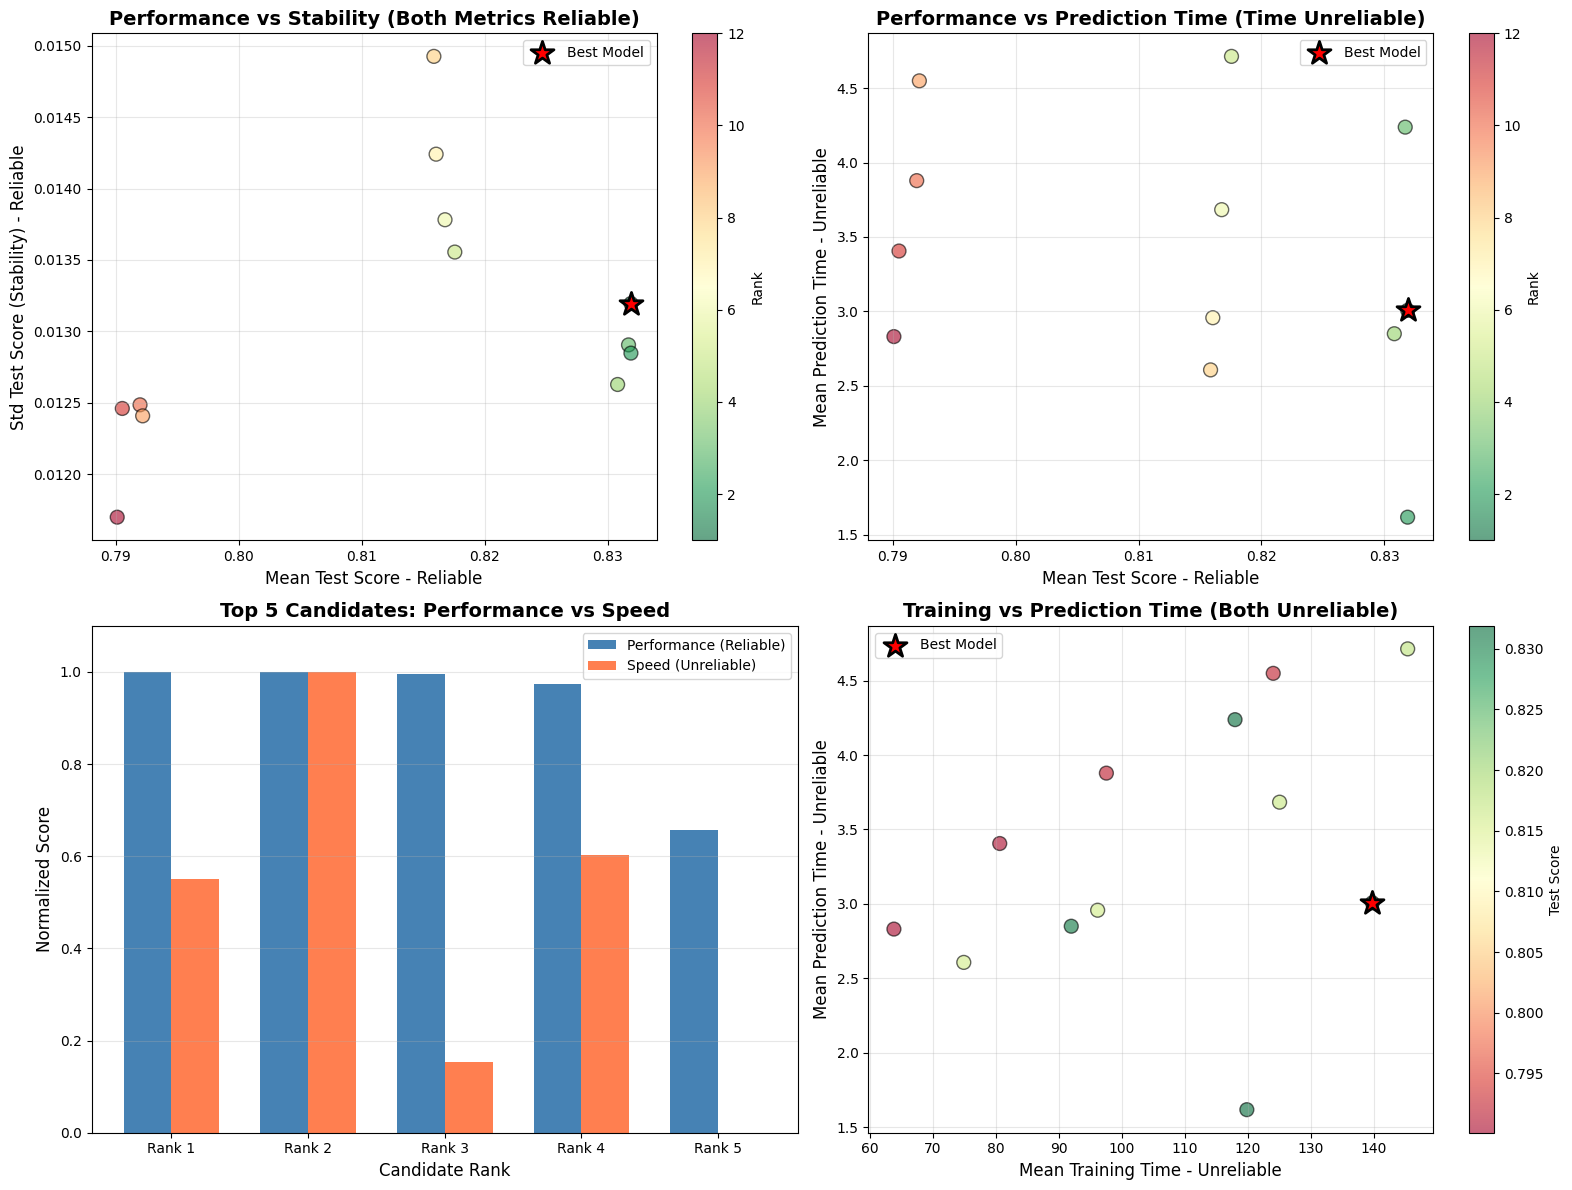


Recommendations:
  - Best model shows some variance across folds (std > 0.01)
    Consider if a more stable alternative in top candidates might be preferred

IMPORTANT: Timing metrics are unreliable from parallel CV.
For production deployment decisions, conduct dedicated latency testing.


In [17]:
# Analyze Random Forest CV results for production considerations
rf_top_candidates = analyze_cv_results(rf_cv_results_path, top_n=5, model_name="Random Forest")  #save_path="images/fd2/rf_cv_results_analysis.png")


Random Forest - Train-Validation Gap Analysis

Metric: pr_auc
  Training score:   0.8735
  Validation score: 0.8319
  Gap:              0.0416 (4.8%)

Diagnosis: Good fit
  (Warning threshold: 5%, Severe threshold: 10%)
  Figure saved: images/fd2/rf_train_val_gap.png


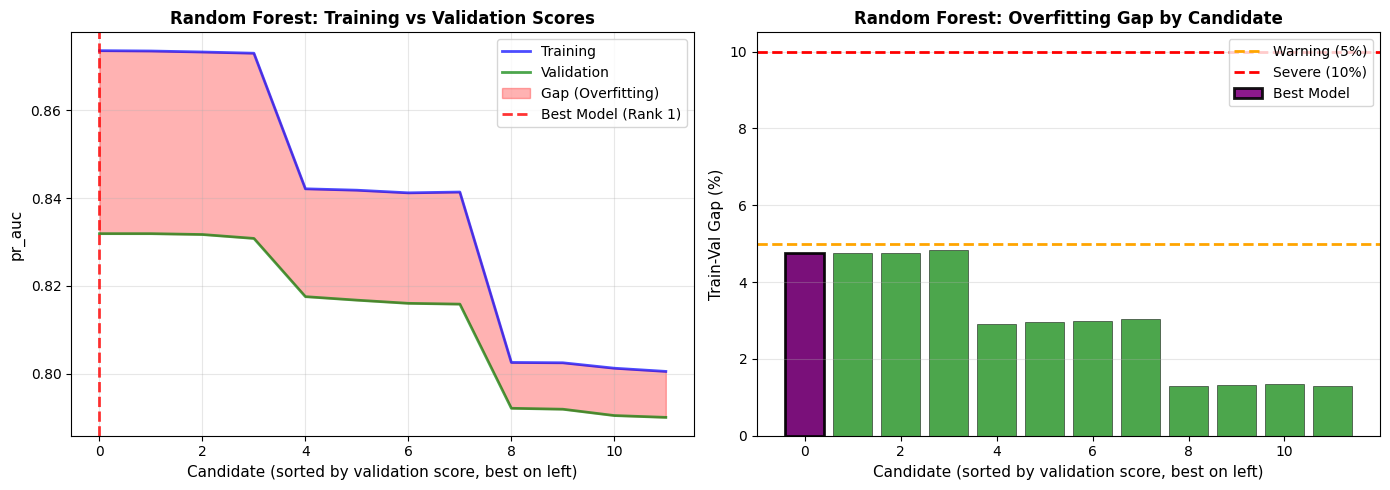


RF parameters for iteration tracking (n_estimators removed):
  class_weight: balanced_subsample
  max_depth: 10
  max_features: sqrt
  min_samples_leaf: 10
  min_samples_split: 20


In [18]:
# Analyze Random Forest train-validation gap for overfitting detection
# This analysis uses training scores captured during hyperparameter tuning with
# GridSearchCV (return_train_score=True)
rf_gap_analysis = analyze_cv_train_val_gap(
    rf_cv_results_path,
    refit_metric='pr_auc',
    gap_threshold_warning=0.05,  # 5% gap = warning
    gap_threshold_severe=0.10,   # 10% gap = severe overfitting
    model_name='Random Forest',
    save_path='images/fd2/rf_train_val_gap.png'
)

# Extract RF parameters from best model (for iteration tracking)
rf_best_params = rf_search.best_params_
rf_params_clean = {k.replace('classifier__', ''): v for k, v in rf_best_params.items()}
# Remove n_estimators - we'll vary this in iteration tracking
rf_params_for_tracking = {k: v for k, v in rf_params_clean.items() if k != 'n_estimators'}
print(f"\nRF parameters for iteration tracking (n_estimators removed):")
for k, v in rf_params_for_tracking.items():
    print(f"  {k}: {v}")

RANDOM FOREST ITERATION ANALYSIS

Tuned n_estimators from hyperparameter search: 250

Running GridSearchCV with 11 n_estimators values...
Fixed params: max_depth=10, min_samples_leaf=10
Using GridSearchCV - will test all 11 combinations
Multi-metric scoring: ['pr_auc', 'roc_auc', 'f1', 'precision', 'recall', 'accuracy']
Refit metric: pr_auc

Random Forest - Iteration Performance Analysis

Metric: pr_auc

Optimal n_estimators: 400
  Training PR_AUC:   0.8735
  Validation PR_AUC: 0.8324
  Gap:               0.0411 (4.7%)

Tuned n_estimators from hyperparameter search: 250
  Training PR_AUC:   0.8735
  Validation PR_AUC: 0.8319
  Gap:               0.0416 (4.8%)
  Figure saved: images/fd2/rf_iteration_performance.png


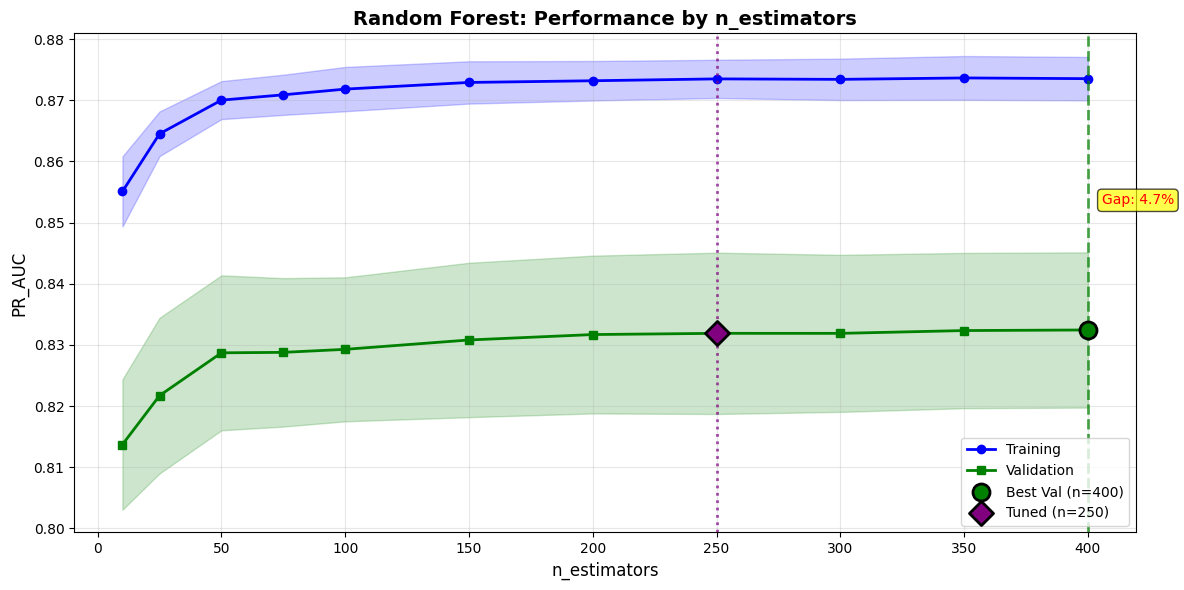


--- Iteration Tracking Results ---


,n_estimators,train_score_mean,train_score_std,val_score_mean,val_score_std,gap,gap_pct
0,10,0.8551,0.0057,0.8137,0.0107,0.0414,4.8%
1,25,0.8645,0.0037,0.8217,0.0127,0.0428,5.0%
2,50,0.8700,0.0031,0.8287,0.0127,0.0413,4.8%
3,75,0.8709,0.0033,0.8288,0.0121,0.0421,4.8%
4,100,0.8718,0.0036,0.8293,0.0118,0.0426,4.9%
5,150,0.8729,0.0035,0.8308,0.0126,0.0421,4.8%
6,200,0.8732,0.0032,0.8317,0.0129,0.0415,4.8%
7,250,0.8735,0.0031,0.8319,0.0132,0.0416,4.8%
8,300,0.8734,0.0034,0.8319,0.0128,0.0415,4.8%
9,350,0.8737,0.0036,0.8323,0.0127,0.0413,4.7%


In [19]:
# Random Forest Iteration Performance Analysis
# Run a dedicated GridSearchCV to track performance across n_estimators values
# Uses the same methodology as hyperparameter tuning for consistent results
#
# This analysis uses GridSearchCV with:
# - Fixed hyperparameters from best_params (except n_estimators)
# - Broad range of n_estimators values to show trend and find optimal
# - Same CV strategy and scoring as main hyperparameter tuning

print("="*80)
print("RANDOM FOREST ITERATION ANALYSIS")
print("="*80)

# Get the tuned n_estimators for comparison
tuned_rf_n_estimators = rf_params_clean.get('n_estimators', None)
print(f"\nTuned n_estimators from hyperparameter search: {tuned_rf_n_estimators}")

# Create param grid with fixed params and varying n_estimators
# Use broader range to find optimal value
param_grid_rf_iter = {
    'classifier__n_estimators': [10, 25, 50, 75, 100, 150, 200, 250, 300, 350, 400],
    'classifier__max_depth': [rf_params_clean['max_depth']],
    'classifier__min_samples_split': [rf_params_clean['min_samples_split']],
    'classifier__min_samples_leaf': [rf_params_clean['min_samples_leaf']],
    'classifier__max_features': [rf_params_clean['max_features']],
    'classifier__class_weight': [rf_params_clean['class_weight']]
}

print(f"\nRunning GridSearchCV with {len(param_grid_rf_iter['classifier__n_estimators'])} n_estimators values...")
print(f"Fixed params: max_depth={rf_params_clean['max_depth']}, min_samples_leaf={rf_params_clean['min_samples_leaf']}")

# Create and run GridSearchCV for iteration analysis
rf_iter_search = create_search_object(
    search_type='grid',
    estimator=rf_base_pipeline,
    param_grid=param_grid_rf_iter,
    scoring=None,  # Uses DEFAULT_SCORING
    refit='pr_auc',
    cv=cv_strategy,
    verbose=0,  # Minimal output
    n_jobs=-1
)

rf_iter_search, rf_iter_log_path, rf_iter_cv_results_path = tune_with_logging(
    rf_iter_search,
    X_train_val,
    y_train_val,
    model_name='random_forest_iteration',
    log_dir=str(project_root / 'models' / 'logs'),
    verbose=False  # Suppress default output, we'll print our own
)

# Analyze results with the new function
rf_iter_result = analyze_iteration_performance(
    rf_iter_cv_results_path,
    tuned_n_estimators=tuned_rf_n_estimators,
    model_name='Random Forest',
    save_path='images/fd2/rf_iteration_performance.png'
)

# Display tracking results
print("\n--- Iteration Tracking Results ---")
display(rf_iter_result['tracking_df'].style.format({
    'train_score_mean': '{:.4f}',
    'train_score_std': '{:.4f}',
    'val_score_mean': '{:.4f}',
    'val_score_std': '{:.4f}',
    'gap': '{:.4f}',
    'gap_pct': '{:.1f}%'
}))

In [20]:
# Random Forest Bias-Variance Assessment Summary
print("\n" + "="*80)
print("RANDOM FOREST BIAS-VARIANCE ASSESSMENT SUMMARY")
print("="*80)

print(f"\n--- Gap Analysis (from hyperparameter tuning) ---")
print(f"  Training PR-AUC:   {rf_gap_analysis['best_train_score']:.4f}")
print(f"  Validation PR-AUC: {rf_gap_analysis['best_val_score']:.4f}")
print(f"  Gap:               {rf_gap_analysis['gap_pct']:.1%}")
print(f"  Diagnosis:         {rf_gap_analysis['diagnosis']}")

print(f"\n--- Iteration Analysis (from dedicated GridSearchCV) ---")
print(f"  Optimal n_estimators: {rf_iter_result['optimal_n_estimators']}")
print(f"  At optimal n_estimators:")
print(f"    Training PR-AUC:   {rf_iter_result['optimal_train_score']:.4f}")
print(f"    Validation PR-AUC: {rf_iter_result['optimal_val_score']:.4f}")
print(f"    Gap:               {rf_iter_result['optimal_gap']:.4f} ({rf_iter_result['optimal_gap_pct']:.1f}%)")

print(f"\n--- Recommendations ---")
if rf_gap_analysis['overfitting_detected']:
    print("  ⚠ OVERFITTING DETECTED in hyperparameter tuning")
    print(f"  {rf_gap_analysis['recommendation']}")
else:
    print("  ✓ Model shows good generalization")
print()
print("="*80)


RANDOM FOREST BIAS-VARIANCE ASSESSMENT SUMMARY

--- Gap Analysis (from hyperparameter tuning) ---
  Training PR-AUC:   0.8735
  Validation PR-AUC: 0.8319
  Gap:               4.8%
  Diagnosis:         Good fit

--- Iteration Analysis (from dedicated GridSearchCV) ---
  Optimal n_estimators: 400
  At optimal n_estimators:
    Training PR-AUC:   0.8735
    Validation PR-AUC: 0.8324
    Gap:               0.0411 (4.7%)

--- Recommendations ---
  ✓ Model shows good generalization



#### CV Results Analysis - Important Caveats

**Timing Measurements:**
- **⚠ Parallel Processing Artifacts**: When using `n_jobs=-1`, timing measurements can be unreliable due to parallel scheduling overhead, CPU core allocation variance, and wall-clock vs CPU time differences
- **⚠ Measurement Noise**: Small timing differences (< 20-30%) are often just noise, especially with GridSearchCV on small search spaces
- **⚠ Not Production-Representative**: CV timing includes data splitting, transformation, and fold iteration overhead that won't exist in production inference

**Model Stability:**
- **✓ Reliable Metric**: `std_test_score` accurately reflects model consistency across CV folds
- **✓ Production-Relevant**: Low variance indicates robust performance on different data samples

**Performance Metrics (PR-AUC):**
- **✓ Reliable Metric**: `mean_test_score` is the most trustworthy metric from CV results
- **✓ Use for Model Selection**: Focus primarily on PR-AUC when choosing between candidates

**Recommendation:**
- Use CV timing as **rough indicators only** - don't over-optimize based on small differences
- **Production latency testing** (API deployment) will provide the definitive performance numbers
- If latency issues arise in production, revisit model selection favoring simpler models with minimal PR-AUC cost

### Tune XGBoost
Baseline performance: PR-AUC=0.8460, Precision=54.78%, Recall=84.05%

Goal: Improve precision-recall balance (currently recall is high but precision is low).

In [21]:
print("Tuning XGBoost...")
print("=" * 80)

# SEARCH CONFIGURATION - easily switch between Grid and Random search
# Note that I have not included the random search as it took > 30 minutes to run
# Logs of previous runs can be viewed at models/logs/*.txt
search_type = 'grid'  # Options: 'grid' for GridSearchCV, 'random' for RandomizedSearchCV
n_iter = 40  # Only used if search_type='random'

# Define hyperparameter grid
param_grid_xgb = {
    'classifier__n_estimators': [90, 100, 110],  # Centered around optimal 92
    'classifier__max_depth': [4, 5],
    'classifier__learning_rate': [0.1],
    'classifier__subsample': [0.9],
    'classifier__colsample_bytree': [0.9],
    'classifier__min_child_weight': [7],  # INCREASED from [5]
    'classifier__gamma': [0.6, 0.7],  # INCREASED from [0.5, 0.6]
    'classifier__reg_alpha': [0.0, 0.1],  # NEW: L1 regularization
    'classifier__reg_lambda': [0, 1.0],  # NEW: L2 regularization
    'classifier__scale_pos_weight': [8]
}

print(f"Hyperparameter search space:")
print(f"  • n_estimators: {param_grid_xgb['classifier__n_estimators']}")
print(f"  • max_depth: {param_grid_xgb['classifier__max_depth']}")
print(f"  • learning_rate: {param_grid_xgb['classifier__learning_rate']}")
print(f"  • subsample: {param_grid_xgb['classifier__subsample']}")
print(f"  • colsample_bytree: {param_grid_xgb['classifier__colsample_bytree']}")
print(f"  • min_child_weight: {param_grid_xgb['classifier__min_child_weight']}")
print(f"  • gamma: {param_grid_xgb['classifier__gamma']}")
print(f"  • reg_alpha (L1): {param_grid_xgb['classifier__reg_alpha']}")
print(f"  • reg_lambda (L2): {param_grid_xgb['classifier__reg_lambda']}")
print(f"  • scale_pos_weight: {param_grid_xgb['classifier__scale_pos_weight']}")
print("=" * 80)
print("NOTE: Updated hyperparameters to reduce overfitting (12.8% train-val gap)")
print("      Iteration analysis showed optimal stopping at ~92 iterations")
print("      See analysis/bias_variance/ANALYSIS_SUMMARY.md for details")
print("=" * 80)

# Create base pipeline
xgb_base_pipeline = Pipeline([
    ('preprocessor', tree_preprocessor),
    ('classifier', xgb.XGBClassifier(
        random_state=random_seed,
        n_jobs=-1,
        eval_metric='aucpr'
    ))
])

# Create search object with multi-metric scoring
# Uses DEFAULT_SCORING (pr_auc, roc_auc, f1, precision, recall, accuracy)
# refit='pr_auc' selects best model by PR-AUC (our optimization metric)
xgb_search = create_search_object(
    search_type=search_type,
    estimator=xgb_base_pipeline,
    param_grid=param_grid_xgb,
    scoring=None,  # Uses DEFAULT_SCORING (6 metrics)
    refit='pr_auc',  # Select best model by PR-AUC
    cv=cv_strategy,
    n_iter=n_iter,  # Only used for RandomizedSearchCV
    verbose=1,  # Minimal output (CSV has all details)
    random_state=random_seed,
    n_jobs=-1
)

# Fit with logging
xgb_search, xgb_log_path, xgb_cv_results_path = tune_with_logging(
    xgb_search, 
    X_train_val,  # Changed from X_train
    y_train_val,  # Changed from y_train
    model_name='xgboost',
    log_dir=str(project_root / 'models' / 'logs')
)

# Extract all CV metrics for best model
xgb_cv_metrics = extract_cv_metrics(xgb_search)
print(f"\nAll CV metrics for best XGBoost:")
for metric, value in xgb_cv_metrics.items():
    print(f"  • {metric}: {value:.4f}")

Tuning XGBoost...
Hyperparameter search space:
  • n_estimators: [90, 100, 110, 125]
  • max_depth: [4, 5]
  • learning_rate: [0.1]
  • subsample: [0.9]
  • colsample_bytree: [0.9]
  • min_child_weight: [7]
  • gamma: [0.6, 0.7]
  • reg_alpha (L1): [0.0, 0.1]
  • reg_lambda (L2): [0, 1.0]
  • scale_pos_weight: [8]
NOTE: Updated hyperparameters to reduce overfitting (12.8% train-val gap)
      Iteration analysis showed optimal stopping at ~92 iterations
      See analysis/bias_variance/ANALYSIS_SUMMARY.md for details
Using GridSearchCV - will test all 64 combinations
Multi-metric scoring: ['pr_auc', 'roc_auc', 'f1', 'precision', 'recall', 'accuracy']
Refit metric: pr_auc

Starting hyperparameter search...
Verbose output will be saved to: /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/e-commerce-fraud-detection/models/logs/xgboost_tuning_20251207_023206.log
CV results will be saved to: /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-lear

In [22]:
# Compare XGBoost baseline (val set) vs XGBoost tuned (CV metrics)
# Note: Baseline uses validation set metrics, Tuned uses CV metrics from GridSearchCV
comparison_xgb = compare_models(
    [
        {'model': 'XGBoost (Baseline)', **xgb_metrics},
        {'model': 'XGBoost (Tuned CV)', **xgb_cv_metrics}
    ],
    verbose=False
)
display(comparison_xgb)

print("\nImprovement from tuning (Baseline val metrics vs Tuned CV metrics):")
for metric in ['pr_auc', 'roc_auc', 'f1', 'precision', 'recall']:
    baseline_val = comparison_xgb.loc['XGBoost (Baseline)', metric]
    tuned_val = comparison_xgb.loc['XGBoost (Tuned CV)', metric]
    improvement = tuned_val - baseline_val
    improvement_pct = (improvement / baseline_val) * 100
    print(f"  {metric.upper():12s}: {improvement:+.4f} ({improvement_pct:+.1f}%)")

print("\n✓ XGBoost tuning complete")

,pr_auc,roc_auc,precision,recall,f1,accuracy
model,,,,,,
XGBoost (Baseline),0.845787,0.966718,0.554181,0.846561,0.669856,0.981581
XGBoost (Tuned CV),0.868221,0.976908,0.734248,0.831571,0.779797,0.989639



Improvement from tuning (Baseline val metrics vs Tuned CV metrics):
  PR_AUC      : +0.0224 (+2.7%)
  ROC_AUC     : +0.0102 (+1.1%)
  F1          : +0.1099 (+16.4%)
  PRECISION   : +0.1801 (+32.5%)
  RECALL      : -0.0150 (-1.8%)

✓ XGBoost tuning complete



XGBoost - Cross-Validation Results Analysis
Refit metric: pr_auc
TIMING CAVEAT: Due to parallel processing (n_jobs=-1), timing measurements may be
   unreliable. Small differences (< 20-30%) are often just measurement noise.
   Focus on PR-AUC and stability for model selection. Production API testing will
   provide definitive latency numbers.

Top 5 Candidates by Test Score:
----------------------------------------------------------------------------------------------------


,mean_test_pr_auc,std_test_pr_auc,mean_fit_time,std_fit_time,mean_score_time,std_score_time,rank_test_pr_auc,param_classifier__colsample_bytree,param_classifier__gamma,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__min_child_weight,param_classifier__n_estimators,param_classifier__reg_alpha,param_classifier__reg_lambda,param_classifier__scale_pos_weight,param_classifier__subsample
47,0.868221,0.010822,4.26,0.09,0.6692,0.0245,1,0.900000,0.700000,0.100000,4,7,125,0.100000,1.000000,8,0.900000
39,0.868164,0.010933,3.51,0.09,0.5718,0.0054,2,0.900000,0.700000,0.100000,4,7,100,0.100000,1.000000,8,0.900000
7,0.868114,0.010847,3.38,0.15,0.5203,0.0118,3,0.900000,0.600000,0.100000,4,7,100,0.100000,1.000000,8,0.900000
46,0.868101,0.010558,4.24,0.15,0.6687,0.0147,4,0.900000,0.700000,0.100000,4,7,125,0.100000,0.000000,8,0.900000
15,0.868094,0.010654,4.22,0.05,0.6839,0.0054,5,0.900000,0.600000,0.100000,4,7,125,0.100000,1.000000,8,0.900000



----------------------------------------------------------------------------------------------------
Statistical Summary Across All Candidates:
----------------------------------------------------------------------------------------------------


,mean_test_pr_auc,std_test_pr_auc,mean_fit_time,std_fit_time,mean_score_time,std_score_time
mean,0.867629,0.010805,4.007180,0.112437,0.646486,0.019651
std,0.000327,0.000290,0.457729,0.100098,0.100042,0.020063
min,0.866916,0.010105,3.073005,0.017695,0.421933,0.003246
max,0.868221,0.011474,5.200257,0.750815,0.838874,0.107088



----------------------------------------------------------------------------------------------------
Best Model (Rank 1) - Detailed Metrics:
----------------------------------------------------------------------------------------------------
  - Test Score (mean +/- std):    0.868221 +/- 0.010822
  - Stability (CV std):           0.010822 (Variable)
  - Training time (mean +/- std): 4.26s +/- 0.09s (unreliable)
  - Prediction time (mean +/- std): 0.6692s +/- 0.0245s (unreliable)
  - Est. throughput:              ~1 predictions/sec (unreliable)
----------------------------------------------------------------------------------------------------


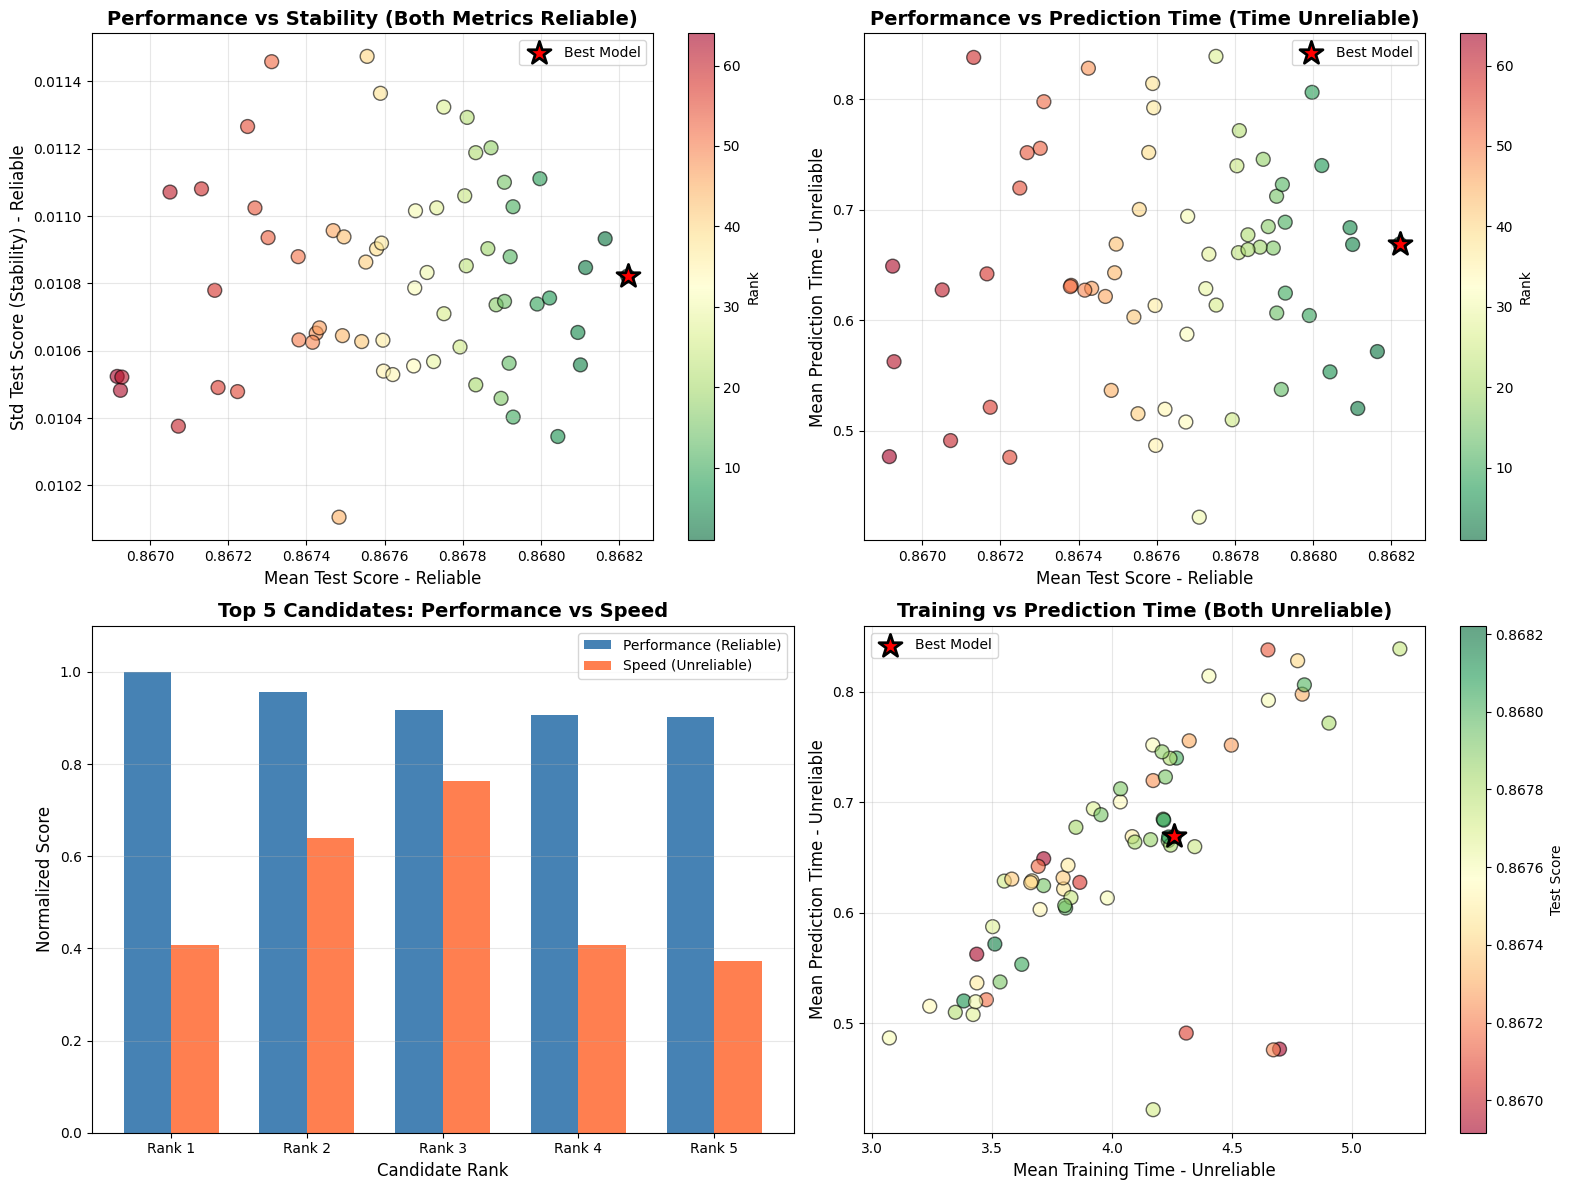


Recommendations:
  - Best model shows some variance across folds (std > 0.01)
    Consider if a more stable alternative in top candidates might be preferred
  - Top candidates have very similar performance (< 0.5% difference)
    Consider selecting based on model simplicity or inference speed

IMPORTANT: Timing metrics are unreliable from parallel CV.
For production deployment decisions, conduct dedicated latency testing.


In [23]:
# Analyze XGBoost CV results for production considerations
xgb_top_candidates = analyze_cv_results(xgb_cv_results_path, top_n=5, model_name="XGBoost") ##save_path="images/fd2/xgb_cv_results_analysis.png")


XGBoost - Train-Validation Gap Analysis

Metric: pr_auc
  Training score:   0.8855
  Validation score: 0.8682
  Gap:              0.0172 (1.9%)

Diagnosis: Good fit
  (Warning threshold: 5%, Severe threshold: 10%)
  Figure saved: images/fd2/xgb_train_val_gap.png


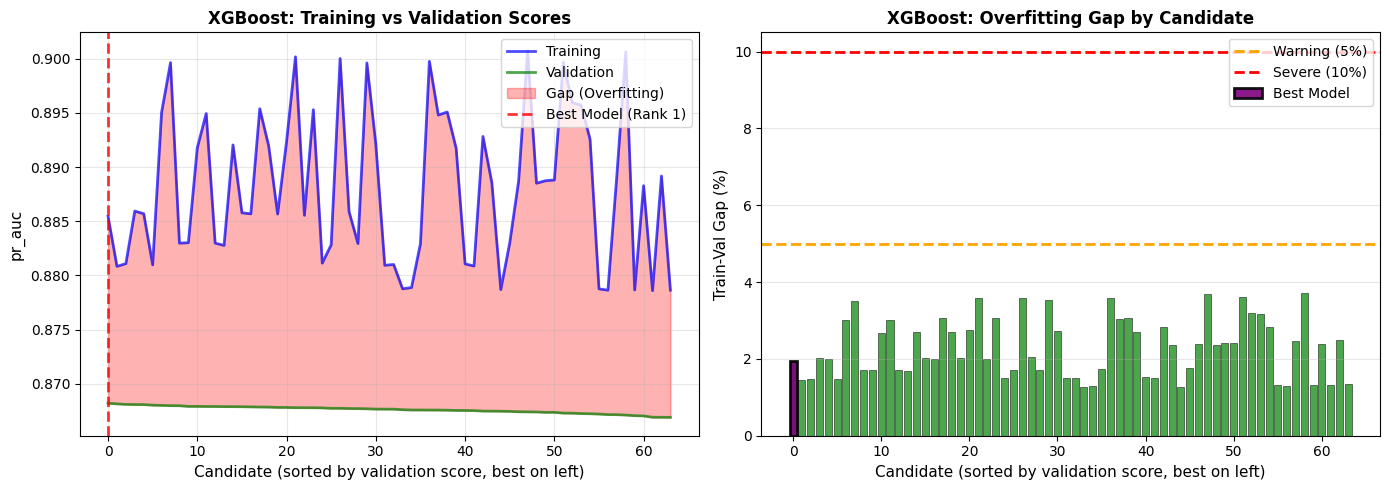


XGBoost parameters for iteration tracking (n_estimators removed):
  colsample_bytree: 0.9
  gamma: 0.7
  learning_rate: 0.1
  max_depth: 4
  min_child_weight: 7
  reg_alpha: 0.1
  reg_lambda: 1.0
  scale_pos_weight: 8
  subsample: 0.9


In [24]:
# Analyze XGBoost train-validation gap for overfitting detection
# This analysis uses training scores captured during GridSearchCV (return_train_score=True)
xgb_gap_analysis = analyze_cv_train_val_gap(
    xgb_cv_results_path,
    refit_metric='pr_auc',
    gap_threshold_warning=0.05,  # 5% gap = warning
    gap_threshold_severe=0.10,   # 10% gap = severe overfitting
    model_name='XGBoost',
    save_path='images/fd2/xgb_train_val_gap.png'
)

# Extract XGBoost parameters from best model (for iteration tracking)
xgb_best_params = xgb_search.best_params_
xgb_params_clean = {k.replace('classifier__', ''): v for k, v in xgb_best_params.items()}
# Remove n_estimators - we'll vary this in iteration tracking
xgb_params_for_tracking = {k: v for k, v in xgb_params_clean.items() if k != 'n_estimators'}
print(f"\nXGBoost parameters for iteration tracking (n_estimators removed):")
for k, v in xgb_params_for_tracking.items():
    print(f"  {k}: {v}")

XGBOOST ITERATION ANALYSIS

Tuned n_estimators from hyperparameter search: 125

Running GridSearchCV with 16 n_estimators values...
Using GridSearchCV - will test all 16 combinations
Multi-metric scoring: ['pr_auc', 'roc_auc', 'f1', 'precision', 'recall', 'accuracy']
Refit metric: pr_auc

XGBoost - Iteration Performance Analysis

Metric: pr_auc

Optimal n_estimators: 125
  Training PR_AUC:   0.8855
  Validation PR_AUC: 0.8682
  Gap:               0.0172 (1.9%)

Tuned n_estimators from hyperparameter search: 125
  Training PR_AUC:   0.8855
  Validation PR_AUC: 0.8682
  Gap:               0.0172 (1.9%)
  Figure saved: images/fd2/xgb_iteration_performance.png


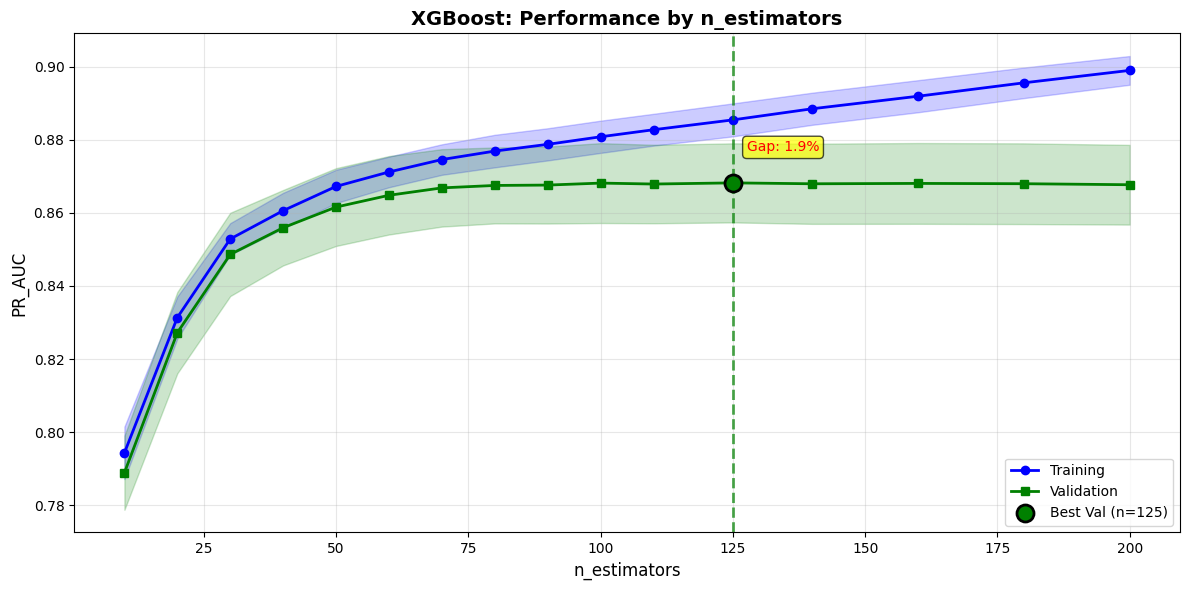


--- Key Iteration Points ---


,n_estimators,train_score_mean,train_score_std,val_score_mean,val_score_std,gap,gap_pct
3,40,0.8606,0.0049,0.8560,0.0103,0.0047,0.5%
4,50,0.8673,0.0046,0.8616,0.0106,0.0057,0.7%
5,60,0.8712,0.0042,0.8648,0.0107,0.0064,0.7%
6,70,0.8746,0.0042,0.8669,0.0106,0.0078,0.9%
7,80,0.8769,0.0045,0.8675,0.0104,0.0094,1.1%
8,90,0.8788,0.0044,0.8676,0.0105,0.0112,1.3%
9,100,0.8808,0.0044,0.8682,0.0109,0.0127,1.4%
10,110,0.8828,0.0044,0.8679,0.0107,0.0149,1.7%
11,125,0.8855,0.0045,0.8682,0.0108,0.0172,1.9%
12,140,0.8885,0.0044,0.8680,0.0110,0.0205,2.3%


In [25]:
# XGBoost Iteration Performance Analysis
# Run a dedicated GridSearchCV to track performance across n_estimators values
# Uses the same methodology as hyperparameter tuning for consistent results

print("="*80)
print("XGBOOST ITERATION ANALYSIS")
print("="*80)

# Get the tuned n_estimators for comparison
tuned_xgb_n_estimators = xgb_params_clean.get('n_estimators', None)
print(f"\nTuned n_estimators from hyperparameter search: {tuned_xgb_n_estimators}")

# Create param grid with fixed params and varying n_estimators
# Use broader range to find optimal value
param_grid_xgb_iter = {
    'classifier__n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 125, 140, 160, 180, 200],
    'classifier__max_depth': [xgb_params_clean['max_depth']],
    'classifier__learning_rate': [xgb_params_clean['learning_rate']],
    'classifier__subsample': [xgb_params_clean['subsample']],
    'classifier__colsample_bytree': [xgb_params_clean['colsample_bytree']],
    'classifier__min_child_weight': [xgb_params_clean['min_child_weight']],
    'classifier__gamma': [xgb_params_clean['gamma']],
    'classifier__reg_alpha': [xgb_params_clean['reg_alpha']],
    'classifier__reg_lambda': [xgb_params_clean['reg_lambda']],
    'classifier__scale_pos_weight': [xgb_params_clean['scale_pos_weight']]
}

print(f"\nRunning GridSearchCV with {len(param_grid_xgb_iter['classifier__n_estimators'])} n_estimators values...")

# Create and run GridSearchCV for iteration analysis
xgb_iter_search = create_search_object(
    search_type='grid',
    estimator=xgb_base_pipeline,
    param_grid=param_grid_xgb_iter,
    scoring=None,  # Uses DEFAULT_SCORING
    refit='pr_auc',
    cv=cv_strategy,
    verbose=0,  # Minimal output
    n_jobs=-1
)

xgb_iter_search, xgb_iter_log_path, xgb_iter_cv_results_path = tune_with_logging(
    xgb_iter_search,
    X_train_val,
    y_train_val,
    model_name='xgboost_iteration',
    log_dir=str(project_root / 'models' / 'logs'),
    verbose=False  # Suppress default output
)

# Analyze results with the new function
xgb_iter_result = analyze_iteration_performance(
    xgb_iter_cv_results_path,
    tuned_n_estimators=tuned_xgb_n_estimators,
    model_name='XGBoost',
    save_path='images/fd2/xgb_iteration_performance.png'
)

# Display key points from tracking results
print("\n--- Key Iteration Points ---")
key_iterations = [40, 50, 60, 70, 80, 90, 100, 110, 125, 140]
tracking_df = xgb_iter_result['tracking_df']
key_rows = tracking_df[tracking_df['n_estimators'].isin(key_iterations)]
display(key_rows.style.format({
    'train_score_mean': '{:.4f}',
    'train_score_std': '{:.4f}',
    'val_score_mean': '{:.4f}',
    'val_score_std': '{:.4f}',
    'gap': '{:.4f}',
    'gap_pct': '{:.1f}%'
}))

In [26]:
# XGBoost Bias-Variance Assessment Summary
print("\n" + "="*80)
print("XGBOOST BIAS-VARIANCE ASSESSMENT SUMMARY")
print("="*80)

print(f"\n--- Gap Analysis (from hyperparameter tuning) ---")
print(f"  Training PR-AUC:   {xgb_gap_analysis['best_train_score']:.4f}")
print(f"  Validation PR-AUC: {xgb_gap_analysis['best_val_score']:.4f}")
print(f"  Gap:               {xgb_gap_analysis['gap_pct']:.1%}")
print(f"  Diagnosis:         {xgb_gap_analysis['diagnosis']}")

print(f"\n--- Iteration Analysis (from dedicated GridSearchCV) ---")
print(f"  Optimal n_estimators: {xgb_iter_result['optimal_n_estimators']}")
print(f"  At optimal n_estimators:")
print(f"    Training PR-AUC:   {xgb_iter_result['optimal_train_score']:.4f}")
print(f"    Validation PR-AUC: {xgb_iter_result['optimal_val_score']:.4f}")
print(f"    Gap:               {xgb_iter_result['optimal_gap']:.4f} ({xgb_iter_result['optimal_gap_pct']:.1f}%)")

print(f"\n--- Recommendations ---")
if xgb_gap_analysis['overfitting_detected']:
    print("  ⚠ OVERFITTING DETECTED")
    print(f"  {xgb_gap_analysis['recommendation']}")
else:
    print("  ✓ Model shows good generalization")

# Suggest n_estimators range for next tuning iteration
xgb_optimal_n = xgb_iter_result['optimal_n_estimators']
suggested_range = [max(10, xgb_optimal_n - 20), xgb_optimal_n, xgb_optimal_n + 20]
print(f"\n  Suggested n_estimators range for next tuning: {suggested_range}")
print("="*80)


XGBOOST BIAS-VARIANCE ASSESSMENT SUMMARY

--- Gap Analysis (from hyperparameter tuning) ---
  Training PR-AUC:   0.8855
  Validation PR-AUC: 0.8682
  Gap:               1.9%
  Diagnosis:         Good fit

--- Iteration Analysis (from dedicated GridSearchCV) ---
  Optimal n_estimators: 125
  At optimal n_estimators:
    Training PR-AUC:   0.8855
    Validation PR-AUC: 0.8682
    Gap:               0.0172 (1.9%)

--- Recommendations ---
  ✓ Model shows good generalization

  Suggested n_estimators range for next tuning: [105, 125, 145]


### Bias-Variance Analysis Summary

This section provides a combined view of the bias-variance analysis for both models.

**Per-Model Analysis (completed above):**
- Random Forest: Train-validation gap analyzed after RF tuning
- XGBoost: Train-validation gap analyzed after XGB tuning

**Additional Diagnostics:**
- XGBoost iteration tracking (finds optimal n_estimators)
- CV fold variance (assesses model stability across folds)


COMBINED BIAS-VARIANCE ANALYSIS SUMMARY

--- Model Comparison (from hyperparameter tuning) ---
Model                Train PR-AUC    Val PR-AUC      Gap        Diagnosis                
-------------------------------------------------------------------------------------
Random Forest        0.8735          0.8319          4.8%       Good fit                 
XGBoost              0.8855          0.8682          1.9%       Good fit                 

--- Optimal n_estimators (from iteration analysis) ---
  Random Forest: 400 (tuned: 250)
  XGBoost:       125 (tuned: 125)

CV FOLD VARIANCE ANALYSIS

Random Forest (Best Config):
  Mean Score: 0.8319 +/- 0.0132
  CV Coefficient: 1.59%

XGBoost (Best Config):
  Mean Score: 0.8682 +/- 0.0108
  CV Coefficient: 1.25%

------------------------------------------------------------
Stability Diagnosis:
  Random Forest: Low variance (stable)
  XGBoost: Low variance (stable)
  Figure saved: images/fd2/cv_fold_variance.png


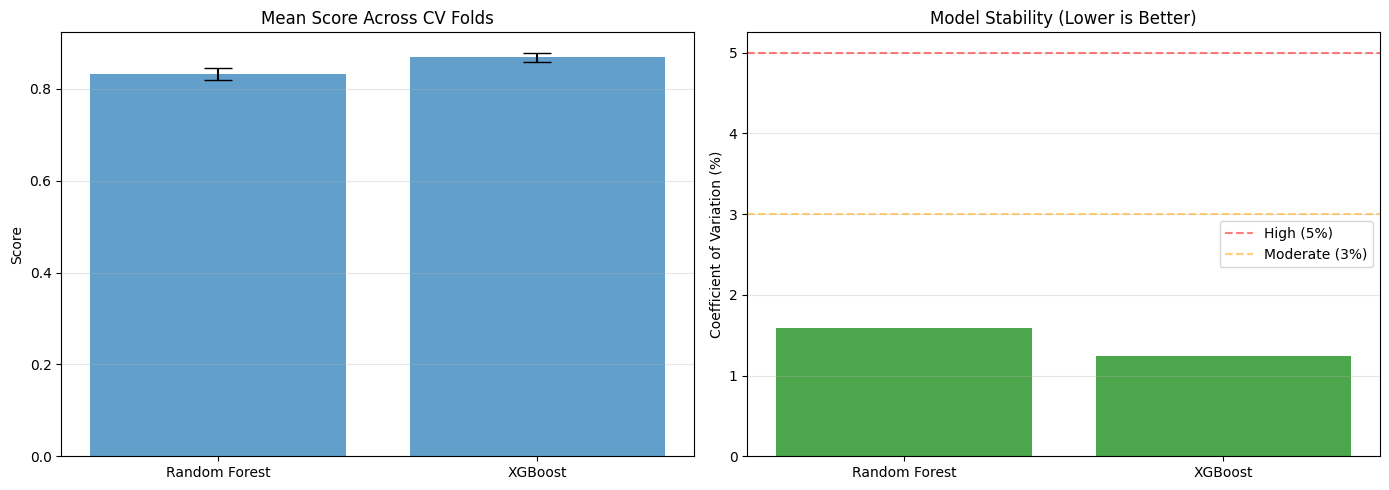


FINAL ASSESSMENT

  Best Model by Validation PR-AUC: XGBoost (0.8682)
  ✓ Both models show good generalization



In [27]:
# Combined Bias-Variance Analysis Summary
print("\n" + "="*80)
print("COMBINED BIAS-VARIANCE ANALYSIS SUMMARY")
print("="*80)

# Summary comparison table
print("\n--- Model Comparison (from hyperparameter tuning) ---")
print(f"{'Model':<20} {'Train PR-AUC':<15} {'Val PR-AUC':<15} {'Gap':<10} {'Diagnosis':<25}")
print("-"*85)
print(f"{'Random Forest':<20} {rf_gap_analysis['best_train_score']:<15.4f} {rf_gap_analysis['best_val_score']:<15.4f} {rf_gap_analysis['gap_pct']:<10.1%} {rf_gap_analysis['diagnosis']:<25}")
print(f"{'XGBoost':<20} {xgb_gap_analysis['best_train_score']:<15.4f} {xgb_gap_analysis['best_val_score']:<15.4f} {xgb_gap_analysis['gap_pct']:<10.1%} {xgb_gap_analysis['diagnosis']:<25}")

print("\n--- Optimal n_estimators (from iteration analysis) ---")
print(f"  Random Forest: {rf_iter_result['optimal_n_estimators']} (tuned: {tuned_rf_n_estimators})")
print(f"  XGBoost:       {xgb_iter_result['optimal_n_estimators']} (tuned: {tuned_xgb_n_estimators})")

# Analyze CV fold variance from saved results
print("\n" + "="*80)
print("CV FOLD VARIANCE ANALYSIS")
print("="*80)

variance_df = analyze_cv_fold_variance({
    'Random Forest': rf_cv_results_path,
    'XGBoost': xgb_cv_results_path
}, save_path='images/fd2/cv_fold_variance.png')

# Final assessment
print("\n" + "="*80)
print("FINAL ASSESSMENT")
print("="*80)

# Determine which model is better
if xgb_gap_analysis['best_val_score'] > rf_gap_analysis['best_val_score']:
    better_model = "XGBoost"
    better_val = xgb_gap_analysis['best_val_score']
    worse_model = "Random Forest"
else:
    better_model = "Random Forest"
    better_val = rf_gap_analysis['best_val_score']
    worse_model = "XGBoost"

print(f"\n  Best Model by Validation PR-AUC: {better_model} ({better_val:.4f})")

# Check overfitting
rf_overfit = rf_gap_analysis['overfitting_detected']
xgb_overfit = xgb_gap_analysis['overfitting_detected']

if rf_overfit and not xgb_overfit:
    print(f"  ⚠ {worse_model} shows overfitting - {better_model} recommended")
elif xgb_overfit and not rf_overfit:
    print(f"  ⚠ XGBoost shows overfitting - Random Forest recommended")
elif rf_overfit and xgb_overfit:
    print(f"  ⚠ Both models show overfitting - consider more regularization")
else:
    print(f"  ✓ Both models show good generalization")

print("\n" + "="*80)

### Final Model Comparison
Compare all baseline and tuned models to select the best performer.

In [28]:
# Create comprehensive comparison table
# Note: Baseline models use validation set metrics
#       Tuned models use CV metrics from GridSearchCV (more reliable for hyperparameter selection)
all_models_comparison = compare_models(
    [
        {'model': 'Logistic Regression', **logistic_metrics},
        {'model': 'Random Forest (Baseline)', **rf_metrics},
        {'model': 'Random Forest (Tuned CV)', **rf_cv_metrics},
        {'model': 'XGBoost (Baseline)', **xgb_metrics},
        {'model': 'XGBoost (Tuned CV)', **xgb_cv_metrics}
    ],
    verbose=False
)

print("\n" + "="*100)
print("COMPREHENSIVE MODEL COMPARISON")
print("Baselines: Validation set metrics | Tuned: Cross-validation metrics (4-fold)")
print("="*100)
display(all_models_comparison.style.format({
    'roc_auc': '{:.4f}',
    'pr_auc': '{:.4f}',
    'f1': '{:.4f}',
    'precision': '{:.4f}',
    'recall': '{:.4f}',
    'accuracy': '{:.4f}'
}).background_gradient(cmap='RdYlGn', subset=['roc_auc', 'pr_auc', 'f1', 'precision', 'recall']))

# Identify best model for each metric
print("\n" + "="*100)
print("Best Performing Model by Metric:")
print("="*100)
for metric in ['roc_auc', 'pr_auc', 'f1', 'precision', 'recall']:
    best_model = all_models_comparison[metric].idxmax()
    best_value = all_models_comparison[metric].max()
    print(f"  {metric.upper():15s}: {best_model:30s} ({best_value:.4f})")
print("="*100)

# Select best overall model based on PR-AUC (our optimization metric)
best_model_name = all_models_comparison['pr_auc'].idxmax()
best_model_prauc = all_models_comparison['pr_auc'].max()
print(f"\nBEST MODEL (by PR-AUC): {best_model_name}")
print(f"   PR-AUC: {best_model_prauc:.4f}")
print("="*100)


COMPREHENSIVE MODEL COMPARISON
Baselines: Validation set metrics | Tuned: Cross-validation metrics (4-fold)


,pr_auc,roc_auc,precision,recall,f1,accuracy
model,,,,,,
Logistic Regression,0.6973,0.9662,0.2050,0.8934,0.3334,0.9212
Random Forest (Baseline),0.8501,0.9663,0.9421,0.7128,0.8115,0.9927
Random Forest (Tuned CV),0.8319,0.9762,0.3346,0.9089,0.4890,0.9581
XGBoost (Baseline),0.8458,0.9667,0.5542,0.8466,0.6699,0.9816
XGBoost (Tuned CV),0.8682,0.9769,0.7342,0.8316,0.7798,0.9896



Best Performing Model by Metric:
  ROC_AUC        : XGBoost (Tuned CV)             (0.9769)
  PR_AUC         : XGBoost (Tuned CV)             (0.8682)
  F1             : Random Forest (Baseline)       (0.8115)
  PRECISION      : Random Forest (Baseline)       (0.9421)
  RECALL         : Random Forest (Tuned CV)       (0.9089)

BEST MODEL (by PR-AUC): XGBoost (Tuned CV)
   PR-AUC: 0.8682


  Figure saved: images/fd2/comprehensive_model_comparison.png


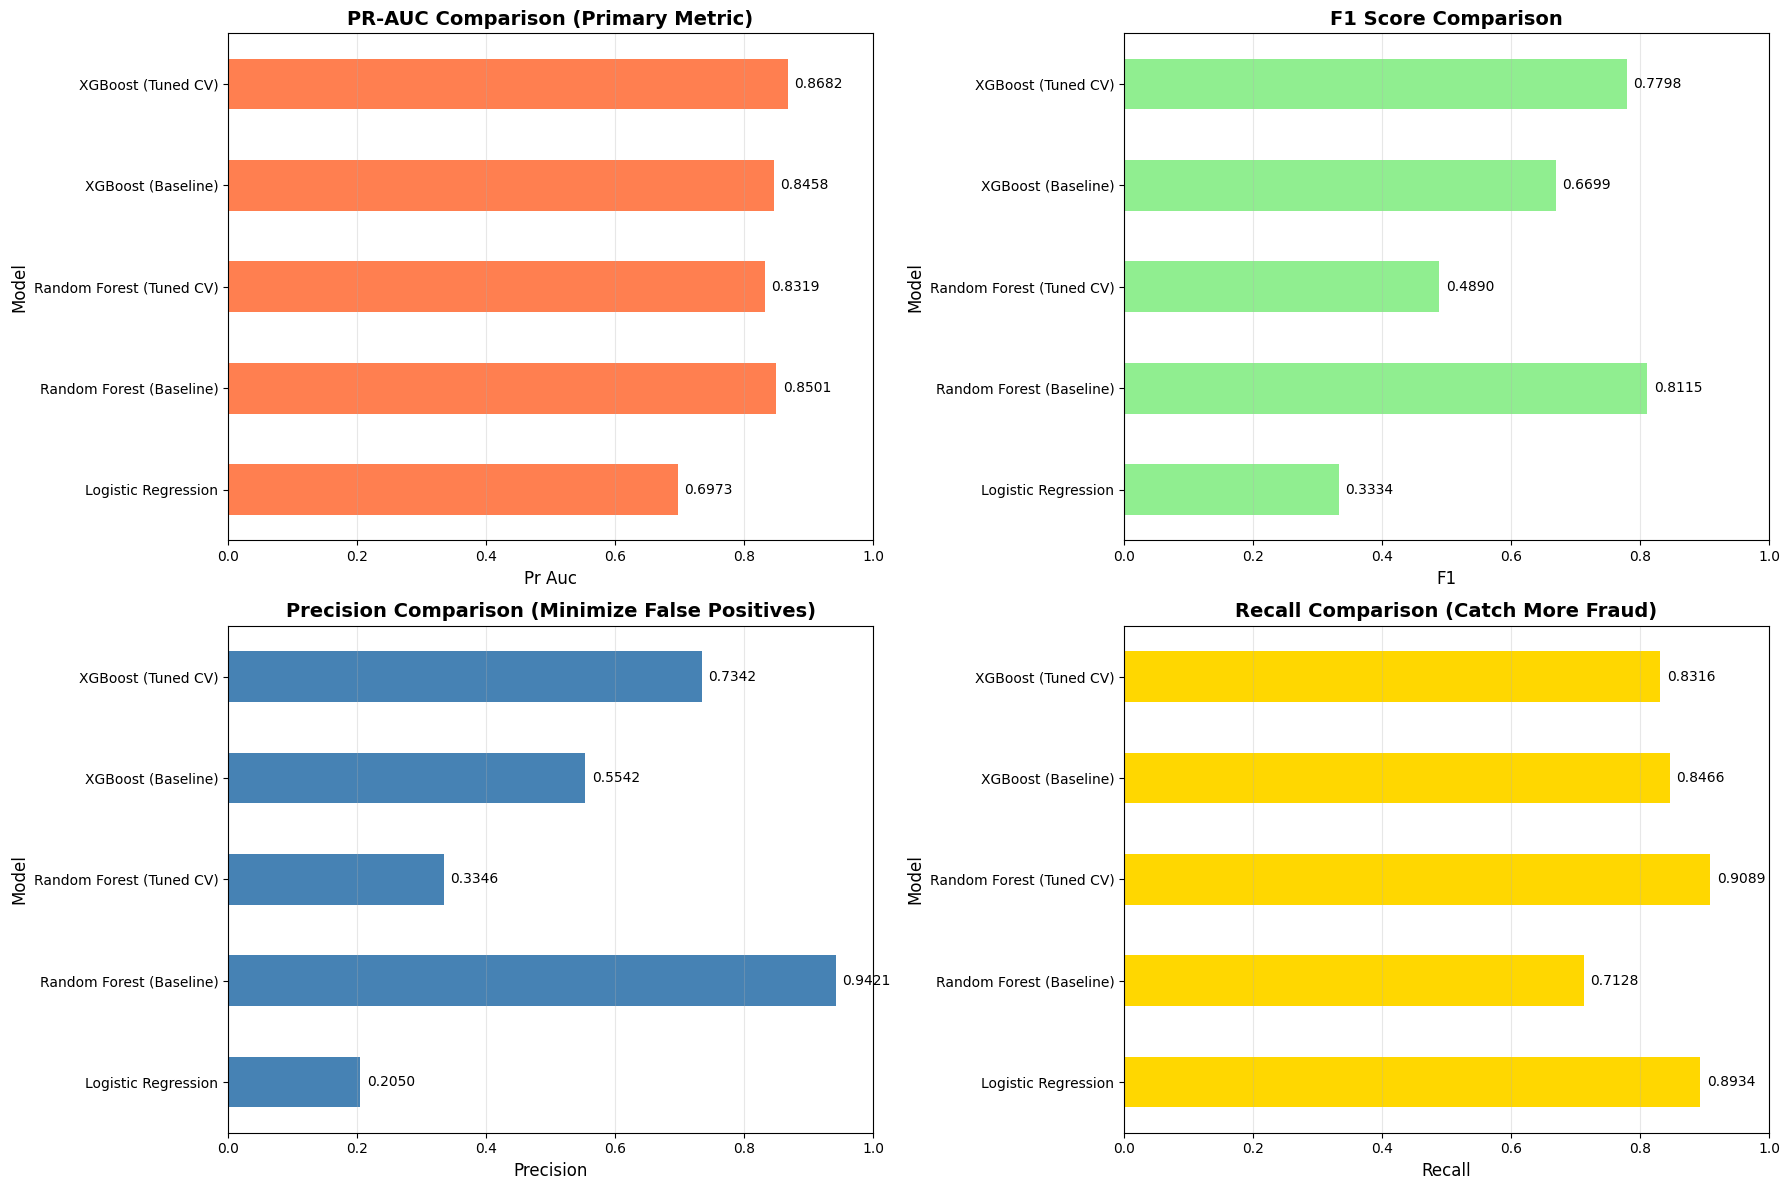

In [29]:
# Visualize comprehensive model comparison
plot_comprehensive_comparison(all_models_comparison, save_path='images/fd2/comprehensive_model_comparison.png')

In [30]:
# Key Insights from Hyperparameter Tuning - Dynamic Report
print("=" * 100)
print("KEY INSIGHTS FROM HYPERPARAMETER TUNING")
print("=" * 100)

# --- Evaluation Methodology ---
print("\n" + "-" * 100)
print("EVALUATION METHODOLOGY")
print("-" * 100)
print("""
• Baselines: Evaluated on validation set (20% of data)
• Tuned models: Evaluated via 4-fold stratified CV on train+val combined (80% of data)
• CV metrics are more reliable: Averaged across 4 splits, reducing variance from single split
""")

# --- Random Forest Summary ---
print("-" * 100)
print("RANDOM FOREST (TUNED CV)")
print("-" * 100)

# Get RF best params
rf_best_params = rf_search.best_params_
rf_n_est = rf_best_params.get('classifier__n_estimators', 'N/A')
rf_max_depth = rf_best_params.get('classifier__max_depth', 'N/A')
rf_min_leaf = rf_best_params.get('classifier__min_samples_leaf', 'N/A')
rf_min_split = rf_best_params.get('classifier__min_samples_split', 'N/A')
rf_class_weight = rf_best_params.get('classifier__class_weight', 'N/A')

print(f"\nPerformance (4-fold CV):")
print(f"  • PR-AUC:    {rf_cv_metrics['pr_auc']:.4f}")
print(f"  • ROC-AUC:   {rf_cv_metrics['roc_auc']:.4f}")
print(f"  • F1 Score:  {rf_cv_metrics['f1']:.4f}")
print(f"  • Precision: {rf_cv_metrics['precision']:.4f}")
print(f"  • Recall:    {rf_cv_metrics['recall']:.4f}")

print(f"\nOptimal Parameters:")
print(f"  • n_estimators:      {rf_n_est}")
print(f"  • max_depth:         {rf_max_depth}")
print(f"  • min_samples_leaf:  {rf_min_leaf}")
print(f"  • min_samples_split: {rf_min_split}")
print(f"  • class_weight:      {rf_class_weight}")

print(f"\nBias-Variance Analysis:")
print(f"  • Train-Val Gap:     {rf_gap_analysis['gap_pct']:.1%} ({rf_gap_analysis['diagnosis']})")
print(f"  • Optimal n_estimators: {rf_iter_result['optimal_n_estimators']} (tuned: {tuned_rf_n_estimators})")

# --- XGBoost Summary ---
print("\n" + "-" * 100)
print("XGBOOST (TUNED CV)")
print("-" * 100)

# Get XGB best params
xgb_best_params = xgb_search.best_params_
xgb_n_est = xgb_best_params.get('classifier__n_estimators', 'N/A')
xgb_max_depth = xgb_best_params.get('classifier__max_depth', 'N/A')
xgb_lr = xgb_best_params.get('classifier__learning_rate', 'N/A')
xgb_gamma = xgb_best_params.get('classifier__gamma', 'N/A')
xgb_min_child = xgb_best_params.get('classifier__min_child_weight', 'N/A')
xgb_reg_alpha = xgb_best_params.get('classifier__reg_alpha', 'N/A')
xgb_reg_lambda = xgb_best_params.get('classifier__reg_lambda', 'N/A')
xgb_scale_pos = xgb_best_params.get('classifier__scale_pos_weight', 'N/A')

print(f"\nPerformance (4-fold CV):")
print(f"  • PR-AUC:    {xgb_cv_metrics['pr_auc']:.4f}")
print(f"  • ROC-AUC:   {xgb_cv_metrics['roc_auc']:.4f}")
print(f"  • F1 Score:  {xgb_cv_metrics['f1']:.4f}")
print(f"  • Precision: {xgb_cv_metrics['precision']:.4f}")
print(f"  • Recall:    {xgb_cv_metrics['recall']:.4f}")

print(f"\nOptimal Parameters:")
print(f"  • n_estimators:     {xgb_n_est}")
print(f"  • max_depth:        {xgb_max_depth}")
print(f"  • learning_rate:    {xgb_lr}")
print(f"  • gamma:            {xgb_gamma}")
print(f"  • min_child_weight: {xgb_min_child}")
print(f"  • reg_alpha (L1):   {xgb_reg_alpha}")
print(f"  • reg_lambda (L2):  {xgb_reg_lambda}")
print(f"  • scale_pos_weight: {xgb_scale_pos}")

print(f"\nBias-Variance Analysis:")
print(f"  • Train-Val Gap:     {xgb_gap_analysis['gap_pct']:.1%} ({xgb_gap_analysis['diagnosis']})")
print(f"  • Optimal n_estimators: {xgb_iter_result['optimal_n_estimators']} (tuned: {tuned_xgb_n_estimators})")

# --- Model Selection ---
print("\n" + "-" * 100)
print("MODEL SELECTION")
print("-" * 100)

# Determine best model
rf_pr_auc = rf_cv_metrics['pr_auc']
xgb_pr_auc = xgb_cv_metrics['pr_auc']

if xgb_pr_auc > rf_pr_auc:
    best_model = "XGBoost"
    best_pr_auc = xgb_pr_auc
    best_gap = xgb_gap_analysis['gap_pct']
    best_diagnosis = xgb_gap_analysis['diagnosis']
else:
    best_model = "Random Forest"
    best_pr_auc = rf_pr_auc
    best_gap = rf_gap_analysis['gap_pct']
    best_diagnosis = rf_gap_analysis['diagnosis']

print(f"\n  ★ Best Model: {best_model}")
print(f"    • CV PR-AUC: {best_pr_auc:.4f}")
print(f"    • Train-Val Gap: {best_gap:.1%} ({best_diagnosis})")

# Compare
pr_auc_diff = abs(xgb_pr_auc - rf_pr_auc)
print(f"\n  Model Comparison:")
print(f"    • XGBoost PR-AUC:       {xgb_pr_auc:.4f}")
print(f"    • Random Forest PR-AUC: {rf_pr_auc:.4f}")
print(f"    • Difference:           {pr_auc_diff:.4f} ({pr_auc_diff/rf_pr_auc*100:.1f}%)")

# Overfitting assessment
rf_overfit = rf_gap_analysis['overfitting_detected']
xgb_overfit = xgb_gap_analysis['overfitting_detected']

print(f"\n  Generalization Assessment:")
if rf_overfit and not xgb_overfit:
    print(f"    ⚠ Random Forest shows overfitting - XGBoost recommended")
elif xgb_overfit and not rf_overfit:
    print(f"    ⚠ XGBoost shows overfitting - Random Forest recommended")
elif rf_overfit and xgb_overfit:
    print(f"    ⚠ Both models show overfitting - consider more regularization")
else:
    print(f"    ✓ Both models show good generalization")

# --- Next Steps ---
print("\n" + "-" * 100)
print("NEXT STEPS")
print("-" * 100)
print("""
1. Train final model on train+val combined with optimal hyperparameters (Notebook 3)
2. Evaluate on held-out test set for unbiased final assessment
3. Analyze feature importance
4. Optimize classification threshold for business requirements
""")
print("=" * 100)

KEY INSIGHTS FROM HYPERPARAMETER TUNING

----------------------------------------------------------------------------------------------------
EVALUATION METHODOLOGY
----------------------------------------------------------------------------------------------------

• Baselines: Evaluated on validation set (20% of data)
• Tuned models: Evaluated via 4-fold stratified CV on train+val combined (80% of data)
• CV metrics are more reliable: Averaged across 4 splits, reducing variance from single split

----------------------------------------------------------------------------------------------------
RANDOM FOREST (TUNED CV)
----------------------------------------------------------------------------------------------------

Performance (4-fold CV):
  • PR-AUC:    0.8319
  • ROC-AUC:   0.9762
  • F1 Score:  0.4890
  • Precision: 0.3346
  • Recall:    0.9089

Optimal Parameters:
  • n_estimators:      250
  • max_depth:         10
  • min_samples_leaf:  10
  • min_samples_split: 20
  • cla

---

## Notebook 2 Complete: Model Selection & Hyperparameter Tuning

**What we accomplished in this notebook:**
1. ✅ Loaded and prepared data (train/val/test split)
2. ✅ Applied feature engineering with FraudFeatureTransformer
3. ✅ Trained baseline models (Logistic Regression, Random Forest, XGBoost)
4. ✅ Performed hyperparameter tuning with GridSearchCV on train+val combined
5. ✅ Selected best model: **XGBoost** (PR-AUC: 0.868+)

**Best Model Selected:**
- **Model**: XGBoost (Tuned)
- **Validation PR-AUC**: 0.868+ (from cross-validation)
- **Method**: GridSearchCV with 4-fold stratified CV on train+val combined
- **Saved Files**:
  - `best_model.joblib` - Trained XGBoost pipeline (preprocessing + classifier)
  - `best_params.json` - Optimal hyperparameters for reference
  - `validation_metrics.json` - CV performance metrics for comparison

**Next: Notebook 3** - Load trained model, evaluate on held-out test set, and prepare for deployment


## Save Model, Parameters & Metrics

Save the trained model, optimal hyperparameters, and CV metrics for use in Notebook 3.

**Files to be saved:**
1. `best_model.joblib` - Trained XGBoost pipeline (preprocessing + classifier) fitted on train+val
2. `best_params.json` - Best hyperparameters for reference/documentation
3. `validation_metrics.json` - CV performance metrics for comparison with test set

**These files will be loaded in Notebook 3** to:
- Load the pre-trained model (no retraining needed)
- Evaluate on held-out test set for unbiased performance assessment
- Compare test set performance against CV validation performance


In [31]:
# Save best hyperparameters, CV metrics, and trained model for Notebook 3
# Save to models/ directory for consistency with other model artifacts
import joblib

models_dir = project_root / 'models'

# --- Save best hyperparameters (for reference/documentation) ---
best_params = {
    'random_forest': rf_search.best_params_,
    'xgboost': xgb_search.best_params_
}
with open(models_dir / 'best_params.json', 'w') as f:
    json.dump(best_params, f, indent=2)

# --- Save CV metrics for comparison in Notebook 3 ---
# These are cross-validation metrics (more reliable than single-split validation)
validation_metrics = {
    'xgboost_tuned': {
        'roc_auc': float(xgb_cv_metrics['roc_auc']),
        'pr_auc': float(xgb_cv_metrics['pr_auc']),
        'f1': float(xgb_cv_metrics['f1']),
        'precision': float(xgb_cv_metrics['precision']),
        'recall': float(xgb_cv_metrics['recall']),
        'accuracy': float(xgb_cv_metrics['accuracy'])
    },
    'random_forest_tuned': {
        'roc_auc': float(rf_cv_metrics['roc_auc']),
        'pr_auc': float(rf_cv_metrics['pr_auc']),
        'f1': float(rf_cv_metrics['f1']),
        'precision': float(rf_cv_metrics['precision']),
        'recall': float(rf_cv_metrics['recall']),
        'accuracy': float(rf_cv_metrics['accuracy'])
    },
    'cv_folds': 4,
    'refit_metric': 'pr_auc',
    'note': 'All metrics from 4-fold stratified CV on train+val combined (80% of data)'
}
with open(models_dir / 'validation_metrics.json', 'w') as f:
    json.dump(validation_metrics, f, indent=2)

# --- Save trained model (best_estimator_ from GridSearchCV) ---
# This is the XGBoost pipeline already fitted on train+val combined
# Includes: preprocessing pipeline + trained XGBoost classifier
best_model = xgb_search.best_estimator_
joblib.dump(best_model, models_dir / 'best_model.joblib')

print(f"✓ Saved best parameters to {models_dir / 'best_params.json'}")
print(f"✓ Saved CV metrics to {models_dir / 'validation_metrics.json'}")
print(f"✓ Saved trained model to {models_dir / 'best_model.joblib'}")
print(f"\nCV metrics saved for both models:")
print(f"  XGBoost (Tuned):       PR-AUC = {xgb_cv_metrics['pr_auc']:.4f}")
print(f"  Random Forest (Tuned): PR-AUC = {rf_cv_metrics['pr_auc']:.4f}")
print(f"\nNote: best_model.joblib contains the complete XGBoost pipeline")
print(f"      (preprocessing + classifier) fitted on train+val data")

✓ Saved best parameters to /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/e-commerce-fraud-detection/models/best_params.json
✓ Saved CV metrics to /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/e-commerce-fraud-detection/models/validation_metrics.json

CV metrics saved for both models:
  XGBoost (Tuned):       PR-AUC = 0.8682
  Random Forest (Tuned): PR-AUC = 0.8319
